# SC-ATACSEQ-EXPLORER PIPELINE

This single cell ATAC-Seq analysis pipeline is designed for intergative analysis of
dataset, initially processed by 10x Genomics.

**In addition** to 10x Genomics results it offers:

* Flexible and clear data preprocessing and normalization methods
* Summary on different conditions in case of aggregated dataset
* Different types of clustering followed by heatmap and t-SNE visualizations in low dimensions space
* Top cluster markers visualization on heatmap / t-SNE plot
* Closest genes annotations for peaks and clusters
* Annotated cell-specific genes analysis
* BigWig and BED files for clusters and markers ready-to-be-visualized in JBR Genome Browser by JetBrains Research
* Data preparation for single cell explorer by Artyomov Lab, Washington University in St.Louis

Required 10x Genomics Cell Cell Ranger ATAC files:

* `fragments.tsv` - fragments matrix file provided by Cell Ranger
* `peaks.bed` - peaks file (union of peaks) in case of merging
* `clusters.csv` - Graph clustering after median normalization, IDF scaling, SVD projection and L2 normalization
* `projection.csv` - T-SNE 2d project of all the cells

<hr>

Other pipelines:

* **Seurat** https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf (not for sc-ATAC-Seq https://github.com/satijalab/seurat/issues/1422)
* **Cell Ranger ATAC-Seq** https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/algorithms/overview
* **Scasat** https://academic.oup.com/nar/article/47/2/e10/5134327
* **SnapATAC** https://www.biorxiv.org/content/10.1101/615179v2
* **Scater** https://academic.oup.com/bioinformatics/article/33/8/1179/2907823

In [1]:
# Configuration
FRAGMENTS_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/BAAJ_Spleen/outs/fragments.tsv.gz'
PEAKS_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/union_peaks.bed'
# PEAKS_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/span_merged_peaks_fdr1e-10_gap0.bed.0E-10_0.bed3'
CLUSTERS_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/BAAJ_Spleen/outs/analysis/clustering/graphclust/clusters.csv'
TSNE_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/BAAJ_Spleen/outs/analysis/tsne/2_components/projection.csv'

# ! wget http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/mm10-mouse/mm10.blacklist.bed.gz
# ! guznip mm10.blacklist.bed.gz
BLACKLIST_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/mm10.blacklist.bed'
# ! wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M22/gencode.vM22.annotation.gtf.gz 
# ! gunzip gencode.vM22.annotation.gtf.gz
GTF_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/gencode.vM22.annotation.gtf'

# representative DNase hypersensitivity sites for mm10 https://www.encodeproject.org/annotations/ENCSR489XTV/
DNASE_FILE = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/ENCFF108APF.bed'

FACTOR = 'age'
FACTORS_MAP = {1: 'old', 2: 'young'}
FACTOR_FUNCTION = lambda x: 1 if x.endswith('-1') else 2

OUTPUT_DIR = '/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline'

In [2]:
MARKER_GENES_TABLE = {
    'B cells': ['Cd19', 'Cd79a', 'Cd79b', 'Pax5'],
    'Naive B celss': ['lghm', 'lghd,' 'Ly6d'],
    'CD4 T cells': ['Cd3d', 'Cd3e', 'Cd3g', 'Cd4'],
    'Regulatory CD4 T cells': ['Il2ra', 'Foxp3', 'Icos', 'Tnfsf18', 'Ikzf2', 'Nrp1'],
    'CD8 T cells': ['Cd3d', 'Cd3e', 'Cd3g', 'Cd8a', 'Cd8b1'],
    'Gamma-delta T cells': ['Cd3d', 'Cd3e', 'Cd3g', 'Tcrg-C1', 'Tcrg-C2', 'Tcrg-C4'],
    'Gamma-delta T cells gdT17': ['Il23a', 'Rorc', 'Il1r1'],
    'NK cells': ['Ncr1', 'Klrc1', 'Klrd1', 'Klrb1c'],
    'Macrophages/Monocytes': ['Adgre1', 'Itgam', 'Trem2', 'Csfr1', 'Cd68'],
    'Neutrophils': ['S100a8', 'S100a9', 'Csfr3', 'Lcn2'],
    'Dendritic cells': ['Flt3', 'Zbtb46', 'Itgax', 'Batf3'],
    'Dendritic cells cDC1': ['Xcr1'],
    'Dendritic cells cDC2': ['Sirpa'],
    'Dendritic cells pDC': ['SiglecH'],
    'Age associated CD8 T cells': ['Gzmk', 'Ccl5', 'Pdcd1', 'Tigit', 'Tox', 'Eomes', 'Maf', 'Lag3']
}

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
sns.set_style("whitegrid")

from pybedtools import BedTool
from tqdm.auto import tqdm
from scipy.stats import zscore

# Fix random seed
np.random.seed(0)

# Overlap of peaks with representative DNAse hypersensitive sites

In [4]:
dnase = BedTool(DNASE_FILE)
peaks_file = BedTool(PEAKS_FILE)
peak_count = peaks_file.count()
overlap = peaks_file.intersect(dnase, wa=True, u=True).count()
peak_by_dnase = 0 if overlap == 0 else overlap * 100.0 / peak_count
overlap = dnase.intersect(peaks_file, wa=True, u=True).count()
dnase_by_peak = overlap * 100.0 / dnase.count()
print('Fraction of peaks overlapping with representative DNAse', int(peak_by_dnase), '%')
print('Fraction of representative DNAse overlapping with peaks', int(dnase_by_peak), '%')

Fraction of peaks overlapping with representative DNAse 96 %
Fraction of representative DNAse overlapping with peaks 8 %


# Code for GTF file preprocessing

In [5]:
print('Preprocess GTF file')

gtf_file = GTF_FILE
transcripts_bed = gtf_file + '.bed'
if not os.path.exists(transcripts_bed):
    GTF_TO_BED_SH = """
TNF=$(cat $1 | grep transcript_id | grep -v '#' | head -n 1 | awk '{for (i=4; i<NF; i++) {if ($3=="transcript" && $i=="gene_name") print (i+1)}}')
cat $1 | awk -v TNF=$TNF -v OFS="\t" '{if ($3=="transcript") {print $1,$4-1,$5,$TNF,0,$7}}' | tr -d '";' | sort -k1,1 -k2,2n -k3,3n --unique > $2
    """
    with tempfile.NamedTemporaryFile(prefix='gtf_to_bed', suffix='.sh', delete=False) as f:
        f.write(GTF_TO_BED_SH.encode('utf-8'))
        f.close()
        ! bash {f.name} {gtf_file} {transcripts_bed} 
print('Transcripts bed file', transcripts_bed)

transcripts_tss = gtf_file + '.tss'
if not os.path.exists(transcripts_tss):
    BED_TO_TSS_SH = """
cat $1 | awk -v OFS="\t" '{if ($6=="+") {print $1, $2, $2+1, $4, 0, "+"} else {print $1,$3-1,$3, $4, 0, "-"}}' | sort -k1,1 -k2,2n -k3,3n --unique > $2
    """
    with tempfile.NamedTemporaryFile(prefix='bed_to_tss', suffix='.sh', delete=False) as f:
        f.write(BED_TO_TSS_SH.encode('utf-8'))
        f.close()
        ! bash {f.name} {transcripts_bed} {transcripts_tss} 
print('Transcripts tss file', transcripts_tss)

Preprocess GTF file
Transcripts bed file /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/gencode.vM22.annotation.gtf.bed
Transcripts tss file /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/gencode.vM22.annotation.gtf.tss


# Code for clusters summary

In [6]:
def clusters_summary(df, value):
    df_sum = df[['cluster', value]].groupby(['cluster']).sum().reset_index()
    df_sum_age = df[['cluster', FACTOR, value]].groupby(['cluster', FACTOR]).sum().reset_index()

    plt.figure(figsize=(10, 4))
    cmap=plt.cm.get_cmap('jet', len(df_sum))
    sns.barplot(x=df_sum.index, y=df_sum[value],
                palette=[cmap(i) for i in range(len(df_sum))])

    plt.show()

    print('Proportions')
    plt.figure(figsize=(10, 4))
    cmap=plt.cm.get_cmap('jet', len(FACTORS_MAP))
    
    # Plot 1 - background - "total" 
    sns.barplot(x = df_sum.index, y = np.ones(len(df_sum)) * 100, color = cmap(0), alpha=0.5)
    
    percentages = np.zeros(len(df_sum))
    for i, (k,v) in enumerate(FACTORS_MAP.items()):
        if i > 0:
            percentages += np.array(df_sum_age.loc[df_sum_age[FACTOR] == k][value]) / np.array(df_sum[value]) * 100.0
            # Plot N - overlay - "bottom" series
            bottom_plot = sns.barplot(x=df_sum.index, y=percentages, color = cmap(i), alpha=0.5)


    legend_colors = [plt.Rectangle((0,0),1,1, fc=cmap(i), edgecolor = 'none') for i in range(len(FACTORS_MAP))]
    legend_names = [v for _,v in FACTORS_MAP.items()]
    l = plt.legend(legend_colors, legend_names, prop={'size':16})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    sns.despine(left=True)
    bottom_plot.set_ylabel('Cluster composition ' + FACTOR + ' %')
    bottom_plot.set_xlabel('Cluster')

    plt.show()

# Code for scatterplot visualization

In [7]:
def plot_colored(data, c, name='component', n_clusters=None, show_centers=False, alpha=0.5):
    """ Plot colored scatterplot """
    cmap = plt.cm.get_cmap('jet', n_clusters) if n_clusters else plt.cm.viridis
    if data.shape[1] >= 3:
        fig, ax = plt.subplots(1, figsize=(12, 10))
        plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
        for i, (c1,c2) in enumerate([(0, 1), (0, 2), (1, 2)]):
            plt.setp(ax, xticks=[], yticks=[])
            plt.subplot(1, 3, i + 1)
            plt.scatter(data[:, c1], data[:, c2], 
                        c=c, 
                        cmap=cmap, 
                        marker='o',
                        edgecolor='none', alpha=alpha)
            plt.xlabel('{} {}'.format(name, c1 + 1))
            plt.ylabel('{} {}'.format(name, c2 + 1))
            plt.colorbar()
    else:
        fig, ax = plt.subplots(1, figsize=(12, 10))
        sc = plt.scatter(data[:,0], data[:,1], 
                         c=c, cmap=cmap,
                         marker='o',
                         edgecolor='none', alpha=alpha)
        plt.setp(ax, xticks=[], yticks=[])
        if n_clusters and show_centers:
            # For each cluster, we add a text with name
            for cluster in range(n_clusters):
                cdata = data[[i for i in range(len(c)) if int(c[i]) == cluster], :]
                cluster_mean = cdata.mean(axis=0)
                plt.text(cluster_mean[0], cluster_mean[1], str(cluster), 
                         horizontalalignment='center', size='large', color='black', weight='bold')            
        if n_clusters:
            cbar = plt.colorbar(boundaries=np.arange(n_clusters + 1) + min(c) - 0.5)
            cbar.set_ticks(np.arange(n_clusters) + min(c))
            cbar.set_ticklabels(list(set(c)))
        else:
            plt.colorbar()
    plt.show()

# 10x Genomics Cell Ranger

This section provides additional analysis and visualization of Cell Ranger ATAC output.

In [8]:
clusters10xpath = CLUSTERS_FILE
clusters10xdf = pd.read_csv(clusters10xpath, sep=',')
clusters10xdf['Cluster'] = clusters10xdf['Cluster'].astype(int) - 1 # Clusters start with 1 in 10x
clusters10xdf[FACTOR] = [FACTOR_FUNCTION(bc) for bc in clusters10xdf['Barcode']]
display(clusters10xdf.head())
print('Total clusters', len(set(clusters10xdf['Cluster'])))

Barcode  Cluster  age
0  AAACGAAAGAGAATTC-2        6    2
1  AAACGAAAGAGCACTG-1       12    1
2  AAACGAAAGAGGTCCA-1       16    1
3  AAACGAAAGCTATCCA-1        5    1
4  AAACGAAAGGCACTAG-1        6    1

Total clusters 18


Size of clusters analysis
Summary by age {1: 'old', 2: 'young'}


counts
age         
1    11442.0
2     8562.0

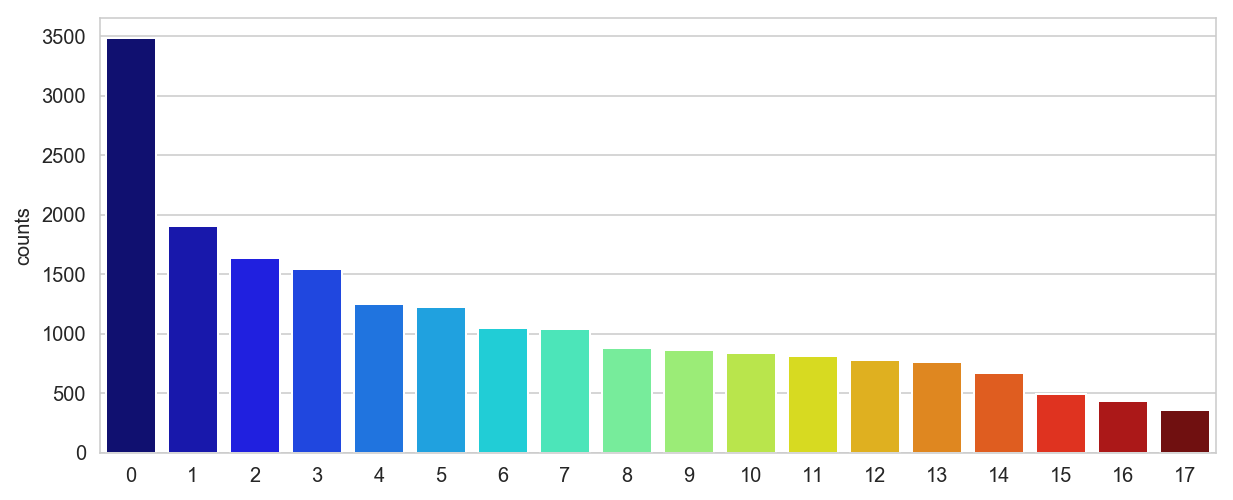

Proportions


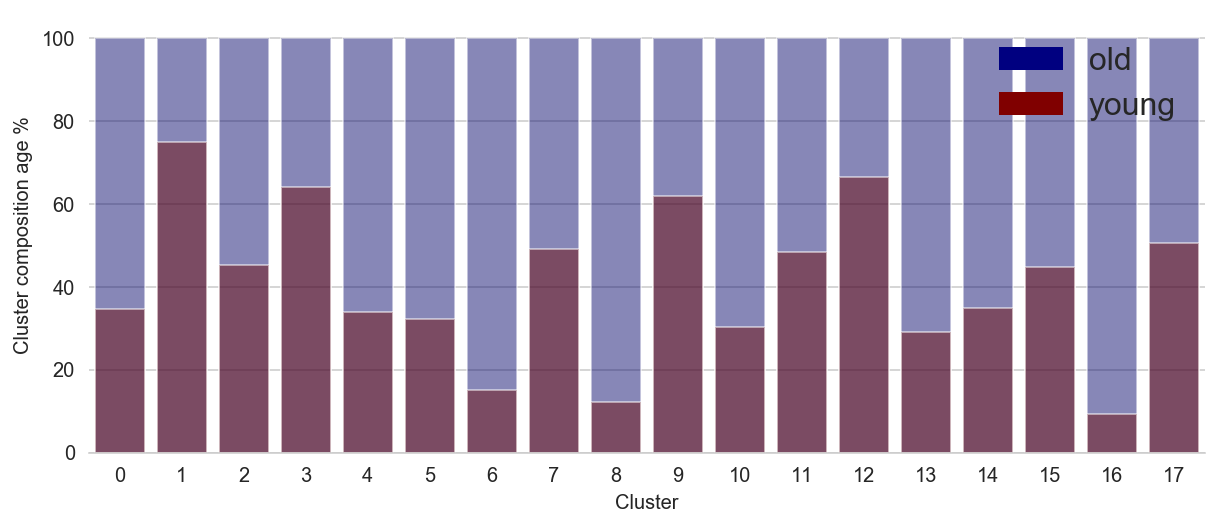

In [9]:
print('Size of clusters analysis')
t = clusters10xdf.copy()
t['counts'] = np.ones(len(t))
t.rename(columns={'Cluster': 'cluster'}, inplace=True)
t.index = t['Barcode']
print('Summary by', FACTOR, FACTORS_MAP)
display(t[[FACTOR, 'counts']].groupby([FACTOR]).sum())

clusters_summary(t[['cluster', 'counts', FACTOR]], 'counts')

In [10]:
# print('Cell Ranger ATAC original T-SNE visualization')
# tsne10xpath = TSNE_FILE
# tsne10xdf = pd.read_csv(tsne10xpath, sep=',')

# mergeddf = pd.merge(left=tsne10xdf,
#                     right=clusters10xdf, 
#                     left_on='Barcode', right_on='Barcode')

# plot_colored(mergeddf[['TSNE-1', 'TSNE-2']].values, mergeddf['Cluster'], 
#              name='tsne', 
#              n_clusters=len(set(mergeddf['Cluster'])),
#              show_centers=True)

In [11]:
# print('tSNE on LSA normalized vs', FACTOR, FACTORS_MAP)
# plot_colored(mergeddf[['TSNE-1', 'TSNE-2']].values, clusters10xdf[FACTOR], 'tsne', 2, alpha=0.2)

<hr>

# SC-ATACSEQ-EXPLORER PIPELINE

* Cell Calling
* Peak barcode matrix
* UMI normalization
* Feature selection
* Dimensionality reduction
* TSNE
* Differential markers analysis
* Supervised annotation of clusters by Gene markers


# Cell Calling

**Pipeline** Use threshold for now!

<hr>

**Cell Ranger ATAC** aggregation: when combining data from multiple GEM groups, the cellranger-atac aggr pipeline automatically equalizes the sensitivity of the groups before merging, which is the recommended approach in order to avoid the batch effect introduced by sequencing depth. **Default method**: Subsample fragments from higher-depth GEM wells until they all have an equal number of unique fragments per cell.

For each barcode:
* we have the record of mapped high-quality fragments that passed all filters (the fragments.tsv file).
* Having determined peaks prior to this, we use the number of fragments that overlap any peak regions.
* Separate the signal from noise.

**This works better in practice as compared to naively using the number of fragments per barcode.** 
We first subtract a depth-dependent fixed count from all barcode counts to model whitelist contamination. This fixed count is the estimated number of fragments per barcode that originated from a different GEM, assuming a contamination rate of 0.02. Then we fit a mixture model of two negative binomial distributions to capture the signal and noise. Setting an odds ratio of 1000, we separate the barcodes that correspond to real cells from the non-cell barcodes.

**Scasat** If a cell has open peaks below a user defined threshold (default: 50 peaks) in the peak accessibility matrix we would remove that cell from subsequent analysis. Also peaks not observed across a user defined number of valid cells (default: 10 cells) are not considered for further downstream analysis.

**SnapATAC** alternative approach -  1kb, 5kb and 10kb resolution.

Existing computational methods rely on **pre-defined** regions of transposase accessibility
identified from the aggregate signals. ...

**Limitations**: 
1. It requires sufficient number of single cell profiles to create robust aggregate signal for peak calling. 
2. The cell type identification is biased toward the most abundant cell types in the tissues. 
3. These techniques lack the ability to reveal regulatory elements in the rare cell populations which are underrepresented in the aggregate signal. This concern is critical, for example, in brain tissue, where key neuron types may represent less than 1% of all cells while still playing a critical role in the neural circuit.


In [12]:
import re

# Fragments file provided by cell ranger
fragments_file_gz = FRAGMENTS_FILE

# BedTools doesn't work with gz file, so unzip it
!gunzip {fragments_file_gz}
fragments_file = re.sub('\.gz', '', fragments_file_gz)

gunzip: can't stat: /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/BAAJ_Spleen/outs/fragments.tsv.gz (/Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/BAAJ_Spleen/outs/fragments.tsv.gz.gz): No such file or directory


In [13]:
# Intersect using bedtools rather than pybedtools, because they are too slow for files of this size!
import tempfile
import pandas as pd
import numpy as np
import os

def process_peaks_file(fragments_file, peaks_file, blacklist_file, threshold):
    print('Fragments')
    ! wc -l {fragments_file}
    idf = None
    print('Blacklist')
    ! wc -l {blacklist_file}
    print('Peaks')
    ! wc -l {peaks_file}

    with tempfile.TemporaryDirectory(prefix='pipeline') as td:
        print('Filtering out non-standard chromosomes')
        chr_filtered_file = os.path.join(td, 'chromosome_filtered.bed')
        ! cat {fragments_file} | grep -i -E 'chr[0-9mt]+\t' > {chr_filtered_file}
        ! wc -l {chr_filtered_file}

        print('Blacklist regions filtration')
        blacklist_filtered_file = os.path.join(td, 'blacklist_filtered.bed')
        ! bedtools intersect -v -a {chr_filtered_file} -b {blacklist_file} > {blacklist_filtered_file}
        ! wc -l {blacklist_filtered_file}

        print('Fragments and peaks intersection')
        intersection_file = os.path.join(td, 'intersection.bed')
        ! bedtools intersect -wa -wb -a {blacklist_filtered_file} -b {peaks_file} > {intersection_file}
        ! wc -l {intersection_file}

        idf = pd.read_csv(intersection_file, sep='\t', header=None)
        idf.columns = ['chr', 'start', 'end', 'barcode', 'reads', 'peak_chr', 'peak_start', 'peak_end']    
#     print('Intersection of fragments and peaks')
#     display(idf.head())

    # 10x Genomics Cell Ranger ATAC-Seq marks duplicates
    # 'count' ignores multiple reads per barcode at same position
    pidf = pd.pivot_table(idf, values='reads', index=['barcode'], aggfunc='count')
    pidf.reset_index(level=0, inplace=True)
#     print('Barcode vs number of fragments overlapping peaks')
#     display(pidf.head())

    print('Filtering cells by threshold', threshold)    
    counts = sorted(pidf['reads'], reverse=True)
    ns = range(1, len(counts) + 1)
    df_all = pd.DataFrame(data={'count': counts, 'n': ns})
    df_cells = df_all.loc[df_all['count'] >= threshold]
    df_noise = df_all.loc[df_all['count'] < threshold]

    cells = set(pidf.loc[pidf['reads'] >= threshold]['barcode'])
    idfcells = idf.loc[[c in cells for c in idf['barcode']]]
    print('Estimated number of cells', len(df_cells))

    # create a new plot (with a title) using figure
    plt.figure(figsize=(8, 8))
    plt.plot(np.log10(df_cells['n']), np.log10(df_cells['count']), label='Cell', linewidth=3, color='orange')
    plt.plot(np.log10(df_noise['n']), np.log10(df_noise['count']), label='Noise', linewidth=3, color='blue')
    plt.xlabel('Barcodes')
    plt.ylabel('Log10 fragments overlapping Peaks')
    plt.show()
    
    return idfcells

Fragments
 117241325 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/BAAJ_Spleen/outs/fragments.tsv
Blacklist
     164 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/mm10.blacklist.bed
Peaks
   58114 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/union_peaks.bed
Filtering out non-standard chromosomes
 114810913 /var/folders/td/g2ws4hwj5tj48_j_tsfz8_tc0000gp/T/pipelinetkfgrc2u/chromosome_filtered.bed
Blacklist regions filtration
 114592939 /var/folders/td/g2ws4hwj5tj48_j_tsfz8_tc0000gp/T/pipelinetkfgrc2u/blacklist_filtered.bed
Fragments and peaks intersection
 65547805 /var/folders/td/g2ws4hwj5tj48_j_tsfz8_tc0000gp/T/pipelinetkfgrc2u/intersection.bed
Filtering cells by threshold 170
Estimated number of cells 19348


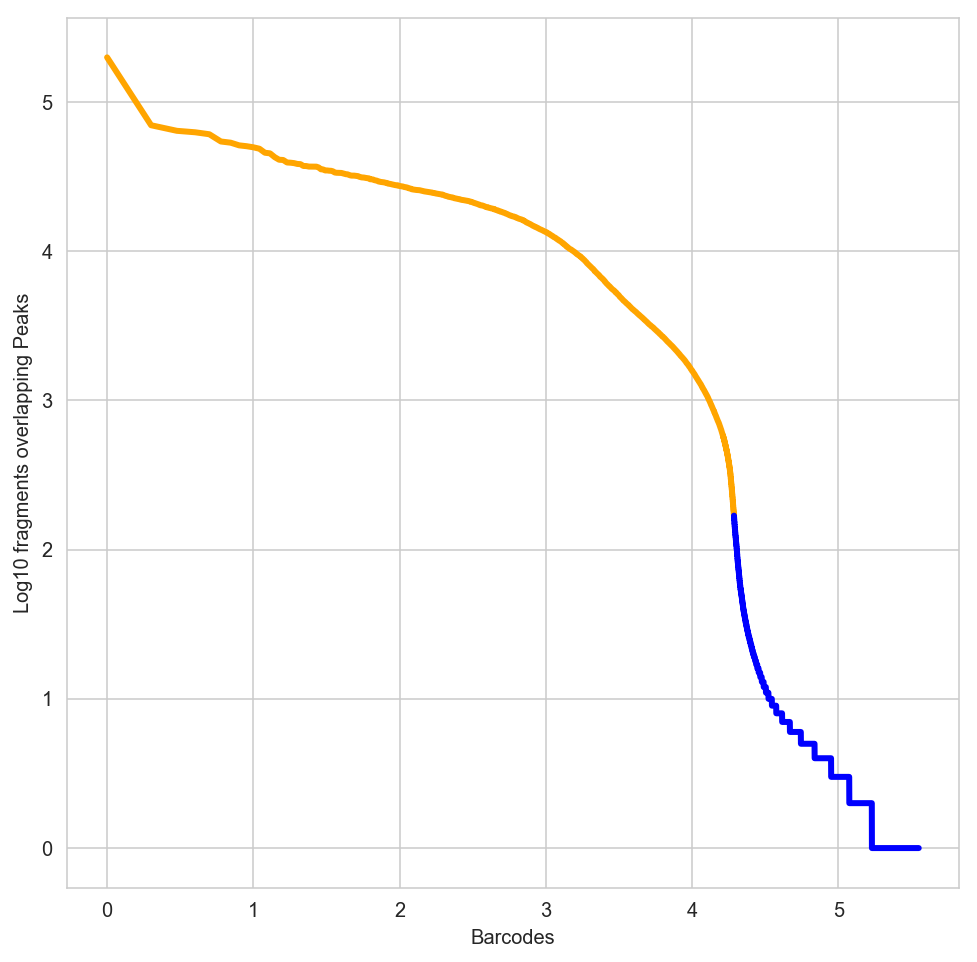

In [14]:
# 10x Cell ranger single cell ATAC-Seq intersection dataframe
idf = process_peaks_file(fragments_file, PEAKS_FILE, BLACKLIST_FILE, threshold=170)

## Peak-Barcode Matrix

**Pipeline**
Compute number of different UMIs which intersect with peak. Multiple copies of UMI are ignored.

<hr>

**Cell Ranger ATAC-Seq**
We produce a count matrix consisting of the counts of fragment ends (or cut sites) within each peak region for each barcode. This is the raw peak-barcode matrix and it captures the enrichment of open chromatin per barcode. The matrix is then filtered to consist of only cell barcodes, which is then used in subsequent analysis such as dimensionality reduction, clustering and visualization.

A barcoded fragment may get sequenced multiple times due to PCR amplification. We mark duplicates in order to identify the original fragments that constitute the library and contribute to its complexity.

In [15]:
print('Barcode vs summary fragments overlap with peaks')
# 10x Genomics Cell Ranger ATAC-Seq marks duplicates
# 'count' ignores multiple reads per barcode at same position
pdf = pd.pivot_table(idf, values='reads', 
                     index=['peak_chr', 'peak_start', 'peak_end', 'barcode'], aggfunc='count').reset_index()

pdf['peak'] = pdf['peak_chr'] + ':' + pdf['peak_start'].astype(str) + '-' + pdf['peak_end'].astype(str)
pdf.drop(columns=['peak_chr', 'peak_start', 'peak_end'], inplace=True)
# display(pdf.head())

Barcode vs summary fragments overlap with peaks


In [16]:
print('Transforming dataframe to peaks x barcode format')
fulldf = pd.pivot_table(pdf, index='peak', columns='barcode', values='reads').fillna(0)
# Remove extra labels from pivot_table columns
fulldf.columns = fulldf.columns.values
fulldf.index.name = None
# display(fulldf.head())

Transforming dataframe to peaks x barcode format


# Normalization

**Pipeline** Global scaling to median coverage of UMI.

<hr>

**Cell Ranger** uses normalization to median coverage depth in each UMI - we do the same here.

**Seurat** we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

**SnapATAC** does not require population-level peak annotation, and instead
assembles chromatin landscapes by directly clustering cells based on the similarity of
their genome-wide accessibility profile. Using a regression-based normalization
procedure, SnapATAC adjusts for differing read depth between cells.

Summary UMI distribution


/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


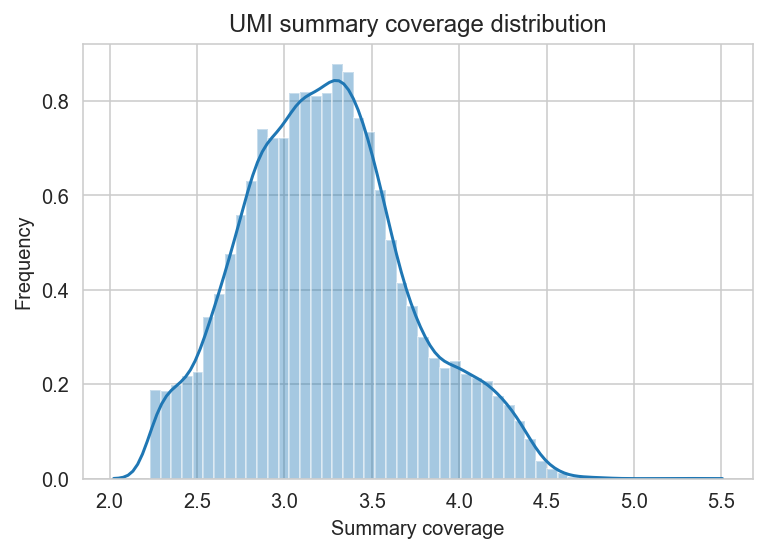

In [17]:
print('Summary UMI distribution')
sns.distplot(np.log10(fulldf.sum()))
plt.title('UMI summary coverage distribution')
plt.xlabel('Summary coverage')
plt.ylabel('Frequency')
plt.show()

Summary UMI distribution per factor
Processing old


/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Processing young


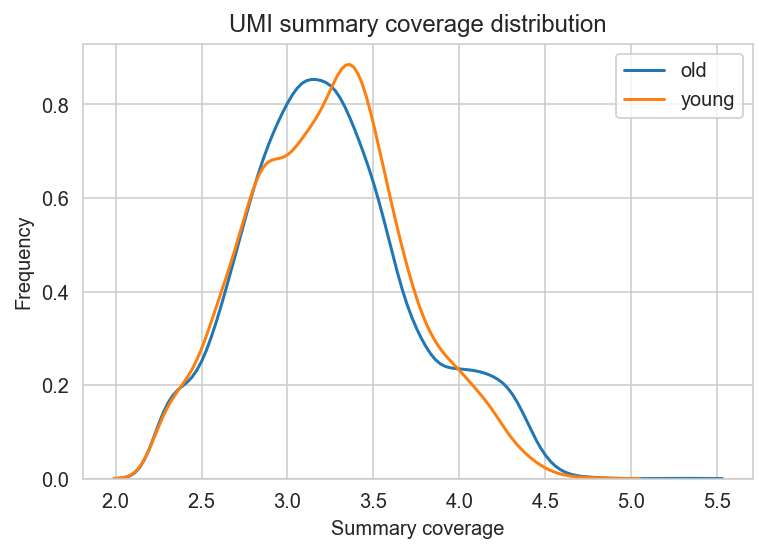

In [18]:
print('Summary UMI distribution per factor')
factors = [FACTOR_FUNCTION(bc) for bc in fulldf.columns]
for k, v in FACTORS_MAP.items():
    print('Processing', v)
    sns.kdeplot(np.log10(fulldf[[c for i, c in enumerate(fulldf.columns) if factors[i] == k]].sum()), label=v)

plt.title('UMI summary coverage distribution')
plt.xlabel('Summary coverage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [19]:
from diffexp import estimate_size_factors

# The same as RPM normalization
print('UMI normalization by median fragments count per barcode') 
# (peaks x barcodes) format
size_factors = estimate_size_factors(fulldf.values)
normdf = fulldf / size_factors # per column, i.e. barcode
scale_factors_df = pd.DataFrame({'scale_factor': 1 / size_factors}, index=fulldf.columns)

UMI normalization by median fragments count per barcode


/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


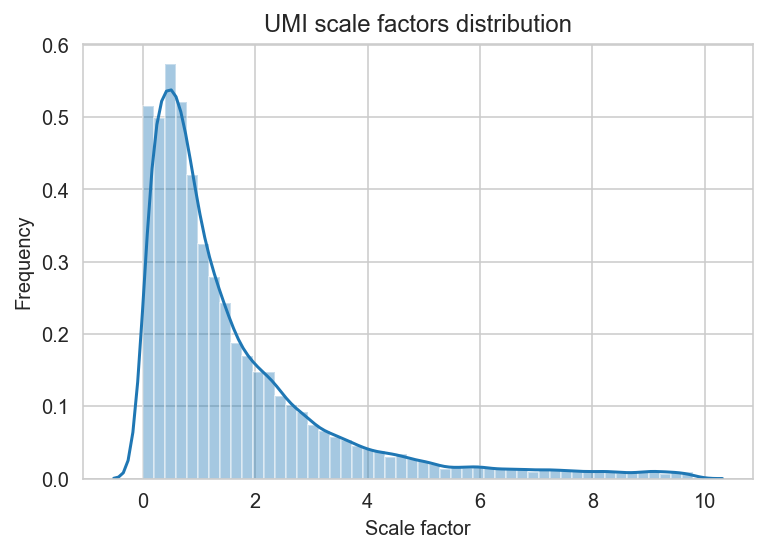

In [20]:
sns.distplot(scale_factors_df['scale_factor'])
plt.title('UMI scale factors distribution')
plt.xlabel('Scale factor')
plt.ylabel('Frequency')
plt.show()

# QC of feature selection, dimensionality reduction, tSNE

Feature selection increases robustness of downstream analysis and should:
* Top coverage peaks should be removed, because they are likely due to sequencing errors or housekeeping genes
* Low coverage peaks should be removed, because likely it is noise

Clustering should:
* produce clusters enough clusters 10-15 recommended by Cell Ranger
* too small clusters are likely artifacts < 100 cells
* centers of clusters should be inside the cluster, otherwise we should increase number of clusters

# Feature selection (Identification of highly variable features)

**Pipeline**
Filter out <1% (as noise) and >99% as alignment errors or housekeeping genes.

<hr>

**SnapATAC**
The vast majority of the items in the cell-by-bin count matrix is “0”, some items have abnormally high coverage (often > 200) perhaps due to alignment error. 
* Removed the top **0.1%** items of the highest coverage

Bins of exceedingly high coverage which likely represent the genomic regions that are invariable between cells such as housekeeping gene promoters were removed. We noticed that filtering bins of extremely low coverage perhaps due to random noise can also improve the robustness of the downstream clustering analysis. 
* Calculated the coverage of each bin using the binary matrix and 
* Normalized the coverage by log10(count + 1). 
* Log-scaled coverage obey approximately a gaussian distribution which is then converted into zscore. 
* Bins with zscore beyond ±2 were filtered before further analysis.


**Cell Ranger ATAC** removed features selection with zero variance.

**Seurat** calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We and others have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

Seurat feature selection visualization
<img src='assets/4.png' width=20%>

In [21]:
def feature_selection(df):
    # df is (peaks x barcodes)
    print('Computing Mean vs SD')
    means = df.T.mean()
    stds = df.T.std()
    plt.figure(figsize=(8, 8))
    g = sns.jointplot(x=means, y=stds)
    plt.title('SD vs Mean for all peaks')
    plt.xlabel('Mean')
    plt.ylabel('SD')
    plt.show()

    logmeans = np.log10(means + 1)
    g = sns.distplot(logmeans)
    plt.title('Mean log coverage in peaks') 
    plt.xlabel('Coverage')
    plt.ylabel('Frequency')
    plt.show()
                
    p_high = np.percentile(logmeans, 99)
    p_low = np.percentile(logmeans, 1)
    peaks_filter = np.logical_and(p_low < logmeans, logmeans < p_high)
            
    print('After feature selection')
    g = sns.distplot(logmeans[np.flatnonzero(peaks_filter)])
    plt.title('Mean log coverage in peaks')
    plt.xlabel('Coverage')
    plt.ylabel('Frequency')
    plt.show()

    print('Total peaks', len(df))
    print('Filtered peaks', sum(peaks_filter))

    return peaks_filter

Computing Mean vs SD


/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 576x576 with 0 Axes>

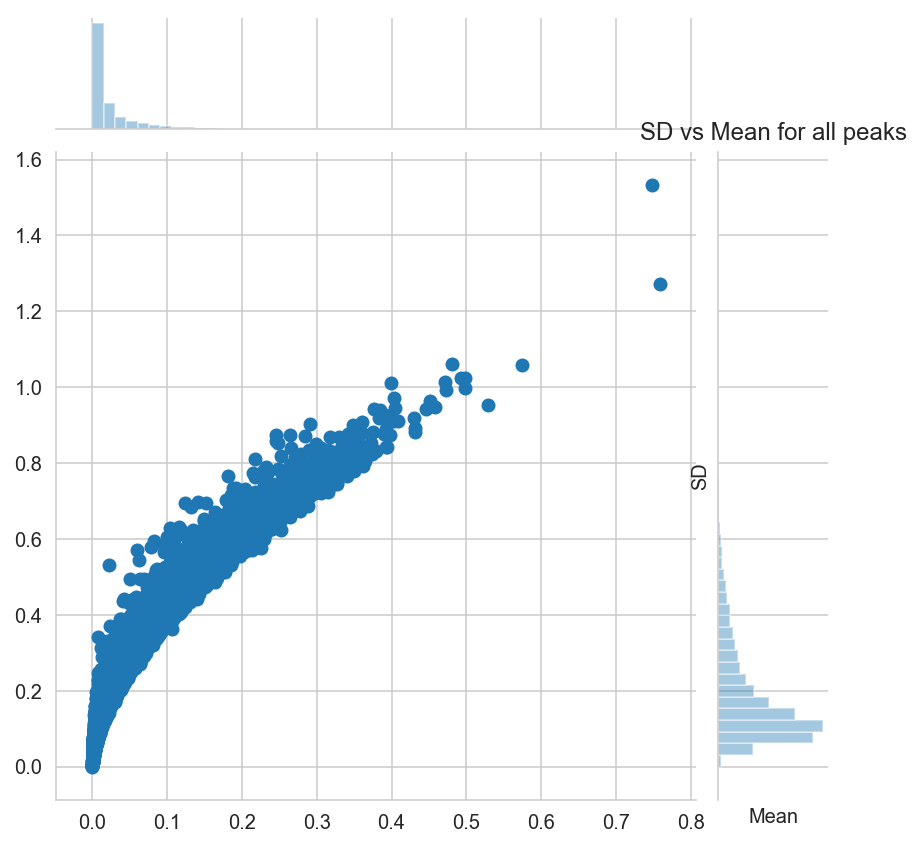

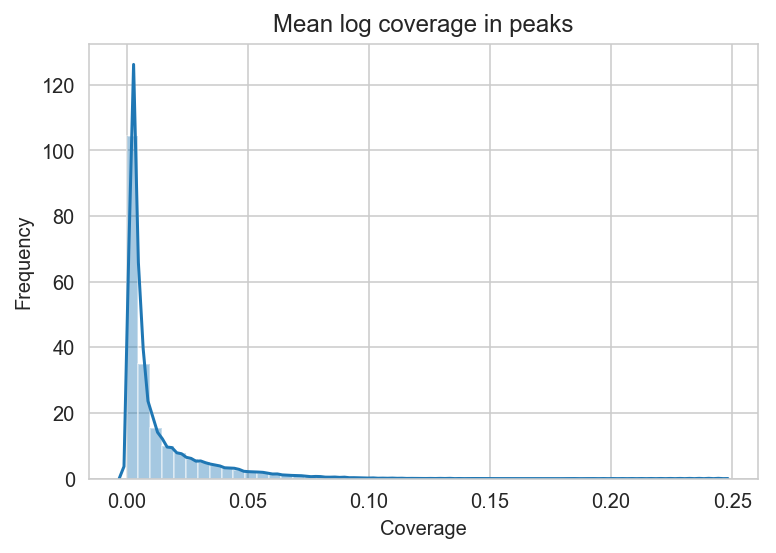

After feature selection


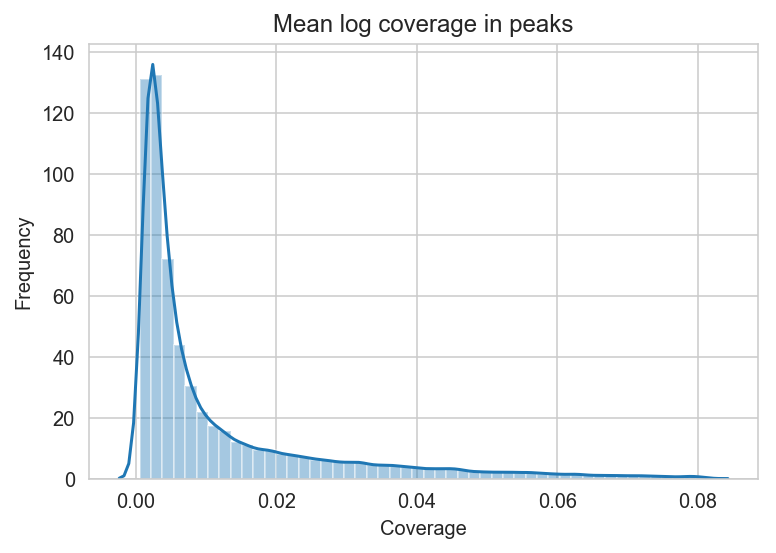

Total peaks 56990
Filtered peaks 55850


In [22]:
peaks_filter = feature_selection(normdf)

# Dimensionality Reduction, Clustering and t-SNE Projection

**Pipeline** Reuse Cell Ranger ATAC approach and IRLB code for dimensionality reduction.

<hr>

**Cell Ranger ATAC** default method is **LSA**.

1. IDF scaling
2. IRLBA SVD decomposition to dim 10
3. L2 normalization in low dimension projection
4. Graph clustering
5. T-SNE visualization

**We found that the combination of these normalization techniques obviates the need to remove the first component.**

## PCA (median and log scaling + classic algorithm)
1. UMI normalization
2. Log scale
3. IRLBA SVD decomposition to dim 10 instead of PCA

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

# print('PCA on features peaks vs log10 sum coverage')
# # Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
# pca = PCA(n_components=15)
# result_pca = pca.fit_transform(np.log1p(normdf.loc[peaks_filter].T)) # X : array-like, shape (n_samples x n_features)
# print('Explained variation', np.sum(pca.explained_variance_ratio_))
# plot_colored(result_pca, np.log10(fulldf.sum()), 'pca')

## LSA (IDF + IRLBA + L2 normalization)

In [24]:
from sklearn.preprocessing import Normalizer
from irlb import irlb

def normalize_by_idf(df):
    print('Normalizing by IDF')
    dfm = {}
    idf_mult = np.log1p(df.shape[1]) - np.log1p(np.count_nonzero(df, axis=1))
    for c in tqdm(df.columns):
        dfm[c] = df[c] * idf_mult
    return pd.DataFrame(dfm, index=df.index)

def lsa(df):
    lsa_norm_mat = normalize_by_idf(df).T # Transpose to (barcodes x peaks) format
    
    print('Performing IRLBA without scaling or centering')
    # Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
    (_, _, v, _, _) = irlb(lsa_norm_mat, 10)
    # project the matrix to complete the transform: X --> X*v = u*d
    transformed_irlba_matrix = lsa_norm_mat.dot(v) 

    # sanity check dimensions
    assert transformed_irlba_matrix.shape == (lsa_norm_mat.shape[0], 10)
    return transformed_irlba_matrix

# NO UMI normalization required for LSA approach!
result_lsa = lsa(fulldf.loc[peaks_filter])

# IMPORTANT! We found that the combination of these normalization techniques 
# obviates the need to remove the first component. Before clustering
print('Normalization each barcode data point to unit L2-norm in the lower dimensional space.')
# X : numpy array of shape (n_samples, n_features) 
result_lsan = pd.DataFrame(Normalizer(norm='l2').fit_transform(result_lsa), 
                           index=result_lsa.index, columns=result_lsa.columns)

Normalizing by IDF



Performing IRLBA without scaling or centering
Normalization each barcode data point to unit L2-norm in the lower dimensional space.


## Graph clustering of LSA normalized data

In [25]:
from collections import Counter
from sklearn.cluster import AgglomerativeClustering

def graph_clustering(result, n_clusters):
    # Ward method as default
    print('Clustering', n_clusters)
    clusters = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(result)
    cluster_counter = Counter()
    for c in clusters:
        cluster_counter[c] += 1

    # reorder clusters by size descending
    clusters_reord = np.zeros(len(clusters))    
    for i, (c, n) in enumerate(cluster_counter.most_common()):
        clusters_reord[clusters == c] = i

    return clusters_reord

# 10 clusters is recommened values by Cell Ranger ATAC-Seq
n_clusters = 10
graph_clusters = graph_clustering(result_lsan, n_clusters)

print('Saving clusters to clusters{}.tsv'.format(n_clusters))
graph_clusters_df = pd.DataFrame({'cluster': graph_clusters})
graph_clusters_df.index = result_lsan.index
graph_clusters_df.to_csv(OUTPUT_DIR + '/clusters{}.tsv'.format(n_clusters))

Clustering 10
Saving clusters to clusters10.tsv


Computing summary for clusters
Summary by age {1: 'old', 2: 'young'}


counts
age         
1    11153.0
2     8195.0

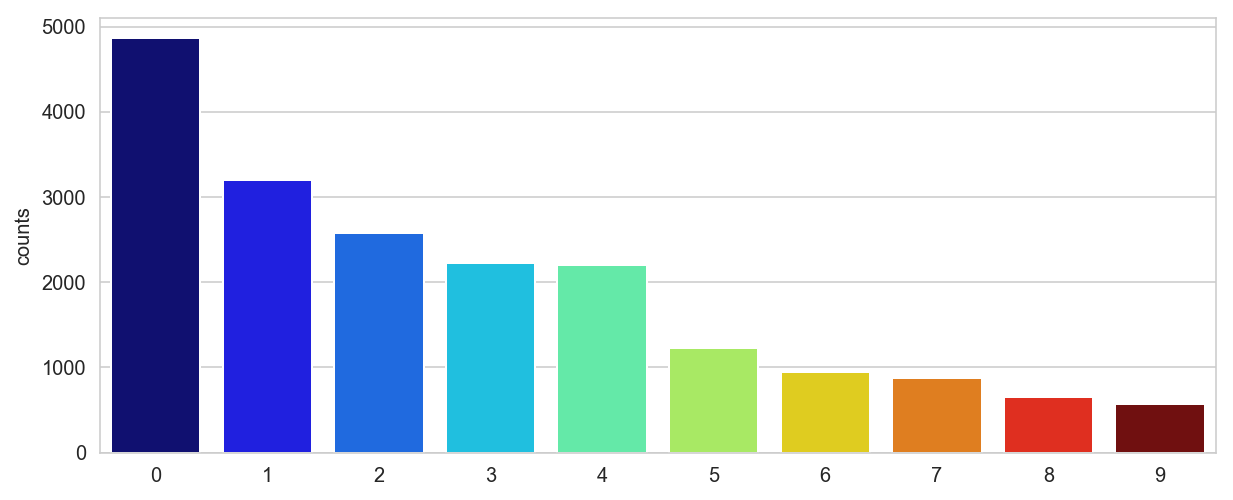

Proportions


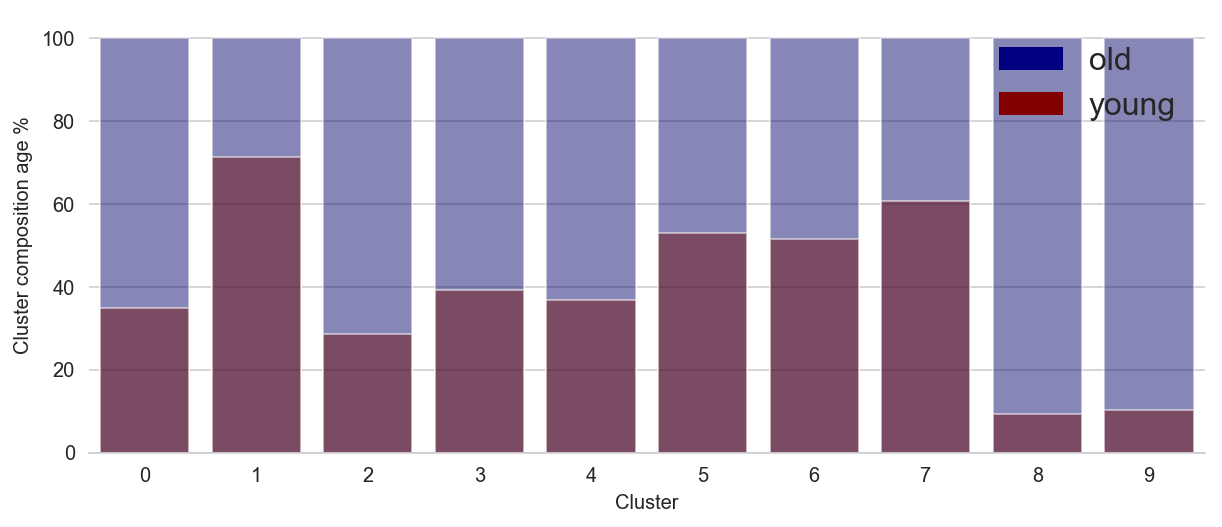

In [26]:
print('Computing summary for clusters')
clustersdf = fulldf.T.copy()
clustersdf[FACTOR] = [FACTOR_FUNCTION(bc) for bc in clustersdf.index]
clustersdf['cluster'] = graph_clusters
clustersdf['counts'] = np.ones(len(clustersdf))

print('Summary by', FACTOR, FACTORS_MAP)
display(clustersdf[[FACTOR, 'counts']].groupby([FACTOR]).sum())

clusters_summary(clustersdf, 'counts')

Sampling 100 cells from cluster



QC: clustermap of normalized LSA coordinates and clusters


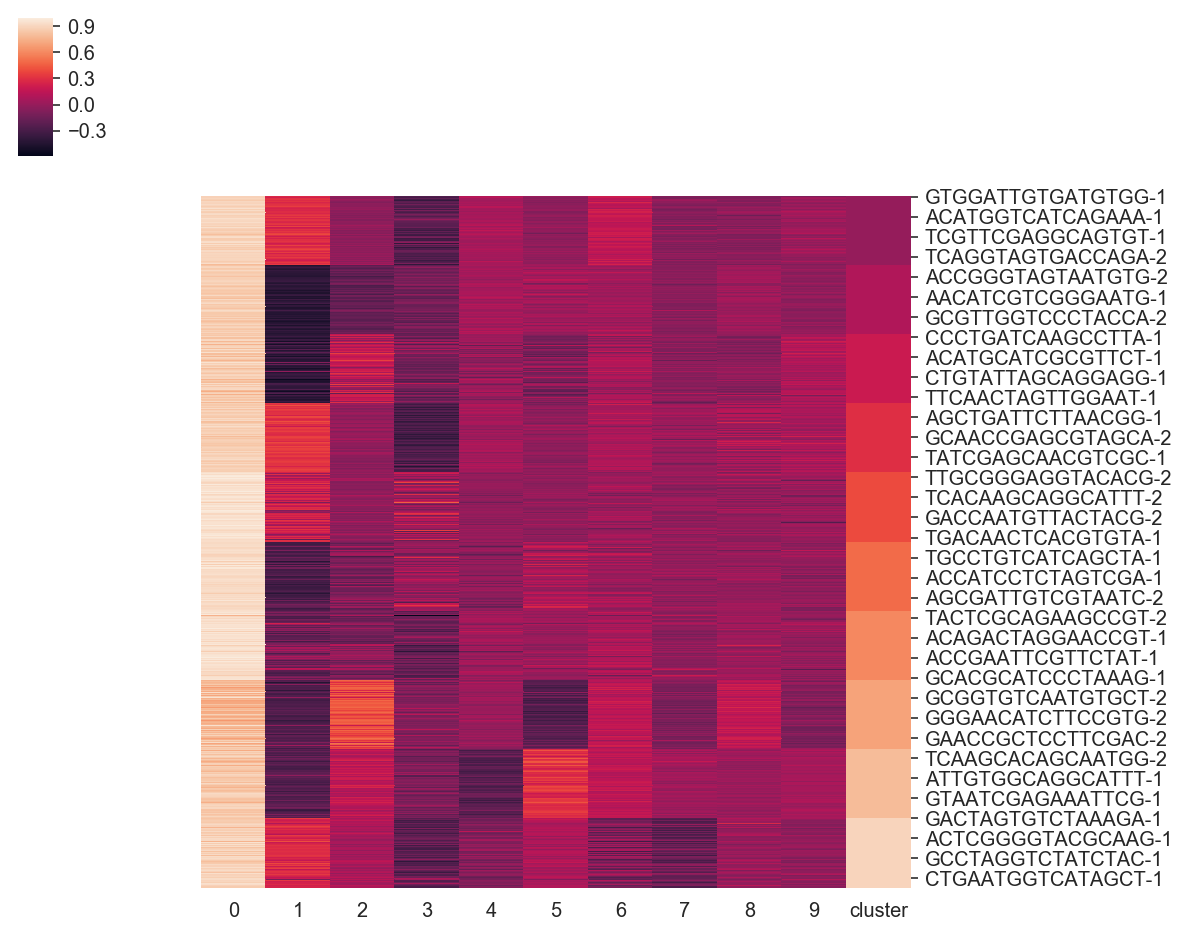

In [27]:
# (barcodes x lsa coordinates) format
t = result_lsan
clusters = graph_clusters
n = 100
print('Sampling', n, 'cells from cluster')
cluster_dfs = []
for cluster in tqdm(range(n_clusters)):
    cluster_df = t.loc[clusters == cluster].sample(n=n, axis=0, replace=True)
    cluster_df['cluster'] = cluster/n_clusters # Normalize cluster number to 0-1
    cluster_dfs.append(cluster_df)
t = pd.concat(cluster_dfs)

print('QC: clustermap of normalized LSA coordinates and clusters')
sns.clustermap(t, col_cluster=False, row_cluster=False, figsize=(8, 8))
plt.show()

Summary UMI distribution per cluster
Processing 0


/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9


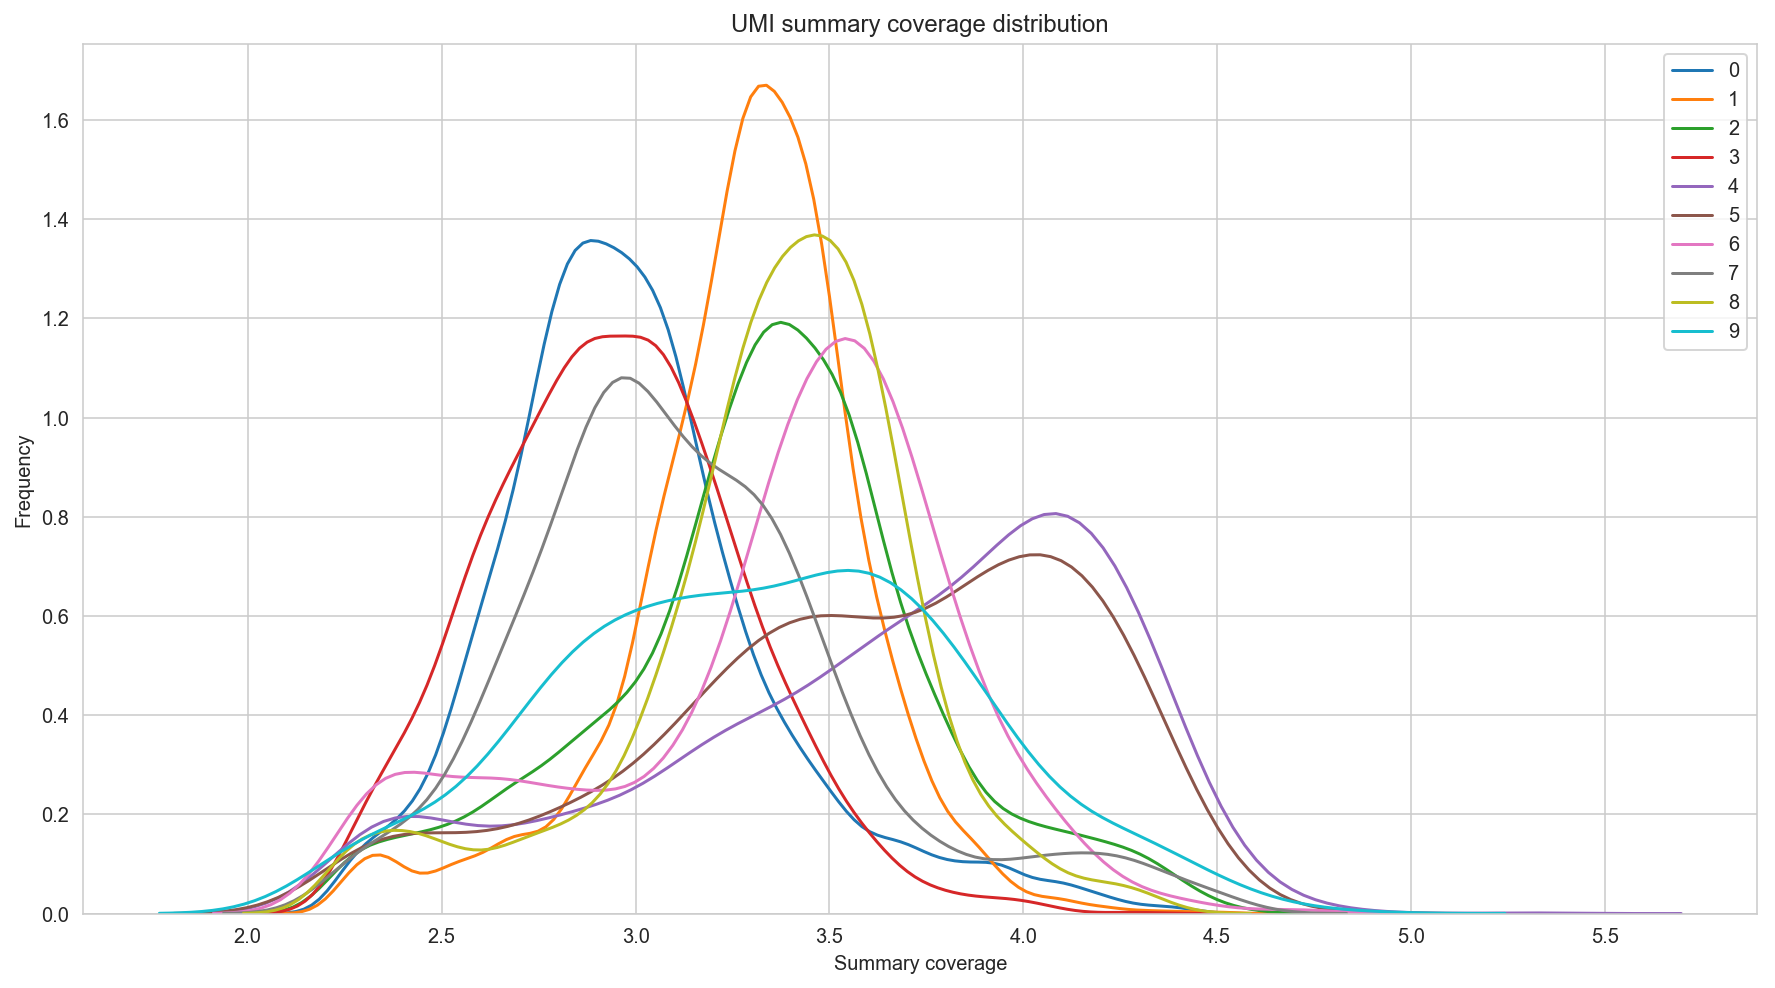

In [37]:
print('Summary UMI distribution per cluster')
plt.figure(figsize=(15, 8))
for c in range(n_clusters):
    print('Processing', c)
    sns.kdeplot(np.log10(fulldf.T.loc[[graph_clusters[i] == c for i in range(len(graph_clusters))]].sum(axis=1)), label=str(c))

plt.title('UMI summary coverage distribution')
plt.xlabel('Summary coverage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# UMAP for dimensionality reduction and visualization

UMAP on LSA normalized vs graph clusters


/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda2/envs/py35/lib/python3.5/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda2/envs/py35/lib/python3.

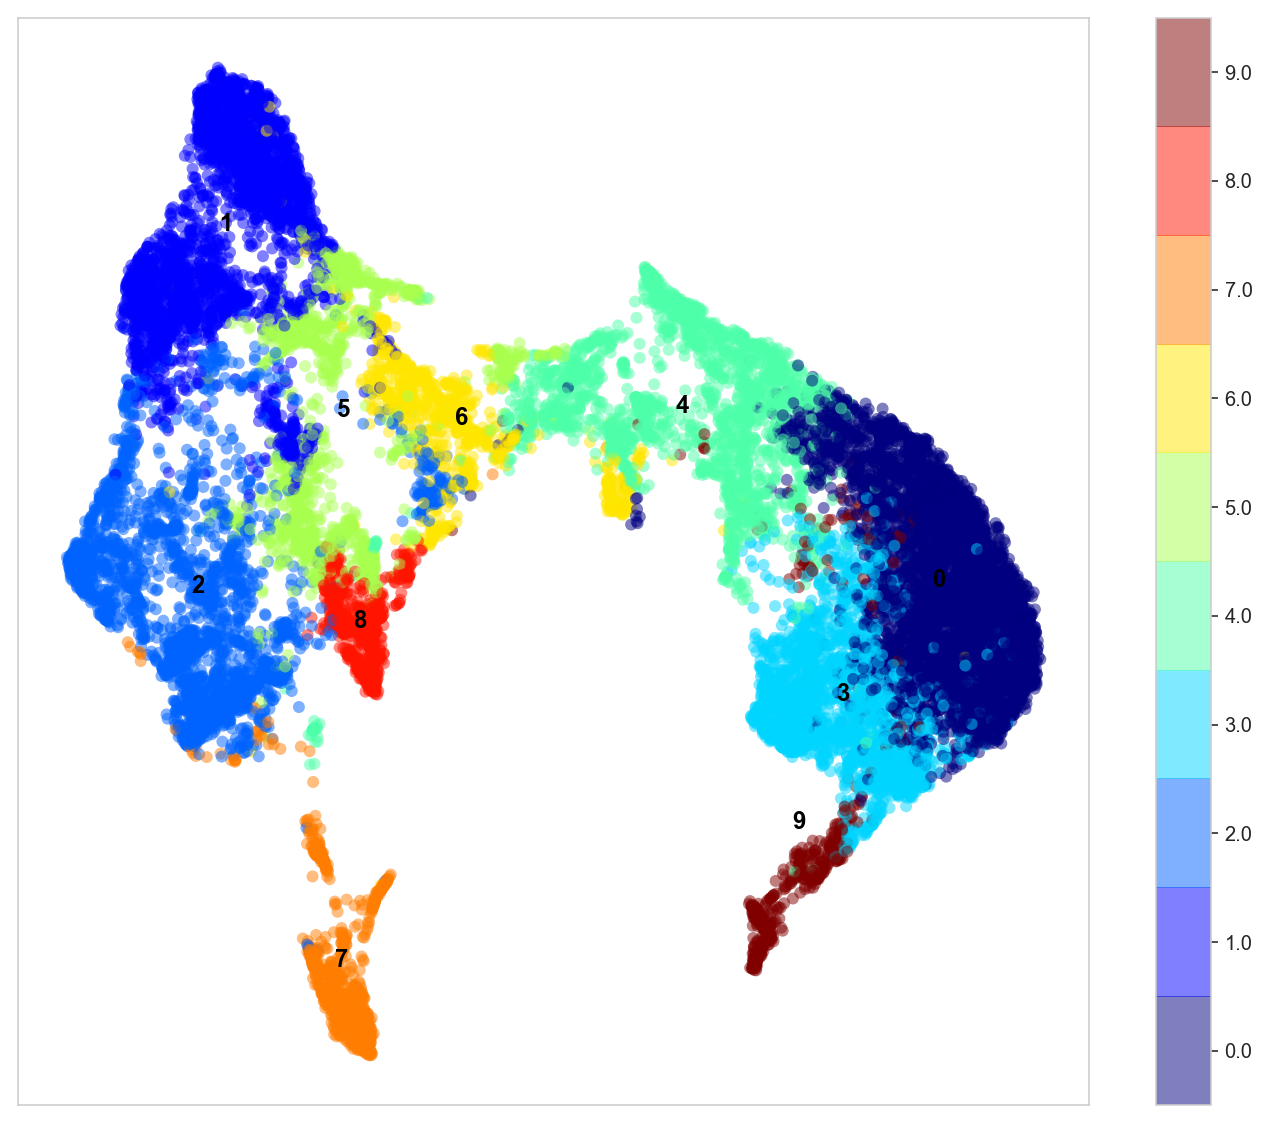

In [37]:
import umap

print('UMAP on LSA normalized vs graph clusters')
plot_colored(umap.UMAP().fit_transform(result_lsan.values), 
             graph_clusters, 'umap', n_clusters, show_centers=True)

## T-SNE

In [30]:
from sklearn.manifold import TSNE
print('Processing t-SNE on L2-normalized data')
results_lsa_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(result_lsan.values),
                                index=result_lsan.index,
                                columns=['tsne1', 'tsne2'])
print('t-SNE done!')
display(results_lsa_tsne.head())

print('Saving tSNE coordinates to tsne.tsv')
results_lsa_tsne.to_csv(OUTPUT_DIR + '/tsne.tsv', sep='\t')

Processing t-SNE on L2-normalized data
t-SNE done!


tsne1      tsne2
AAACGAAAGAGAATTC-2  31.555222  22.233927
AAACGAAAGAGCACTG-1  15.811436  42.148712
AAACGAAAGAGGTCCA-1 -53.886909  41.991974
AAACGAAAGCTATCCA-1 -18.647507   8.839691
AAACGAAAGGCACTAG-1  12.869020  68.770149

Saving tSNE coordinates to tsne.tsv


tSNE on LSA normalized vs log10 coverate depth


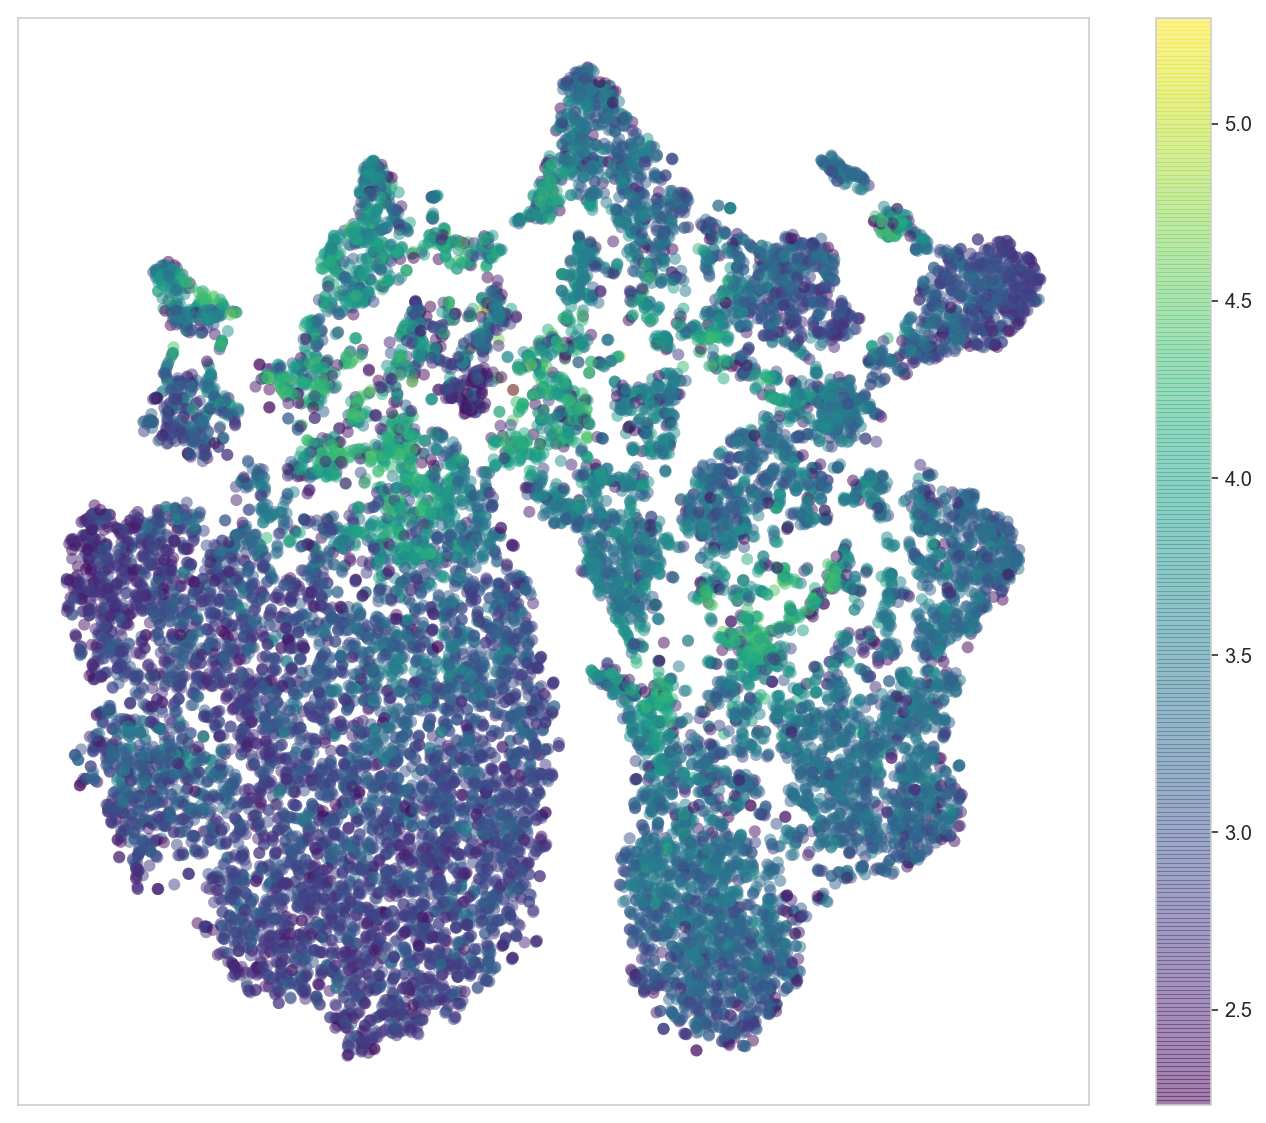

In [31]:
print('tSNE on LSA normalized vs log10 coverate depth')
plot_colored(results_lsa_tsne.values, np.log10(fulldf.sum()), 'tsne')

tSNE on LSA normalized vs age {1: 'old', 2: 'young'}


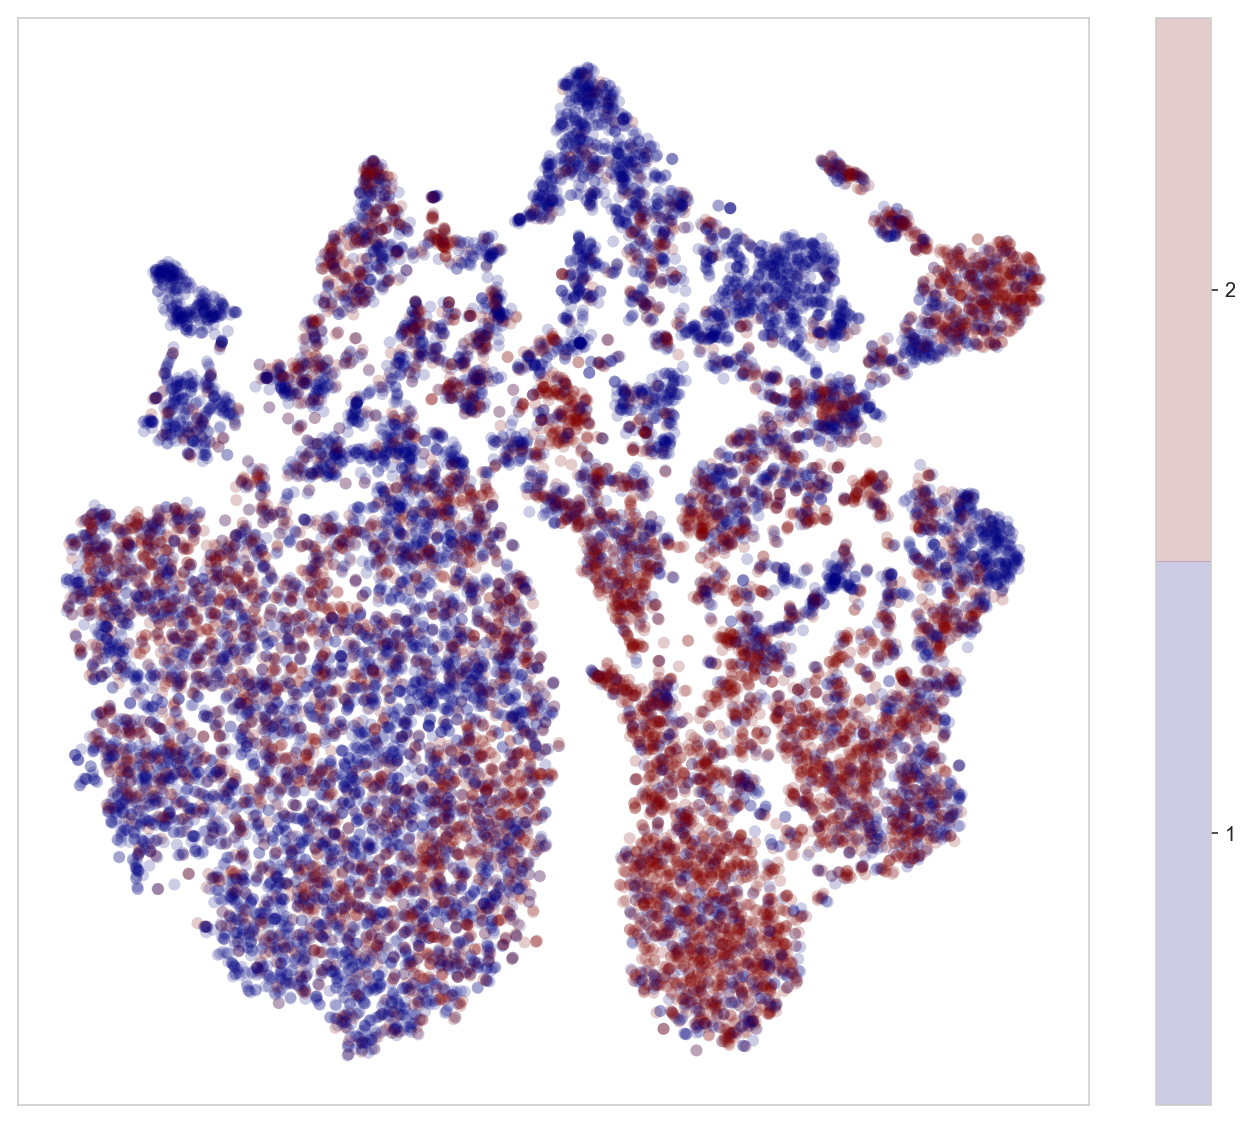

In [32]:
print('tSNE on LSA normalized vs', FACTOR, FACTORS_MAP)
factors = [FACTOR_FUNCTION(bc) for bc in result_lsa.index]
plot_colored(results_lsa_tsne.values, factors, 'tsne', 2, alpha=0.2)

tSNE on LSA normalized vs graph clusters


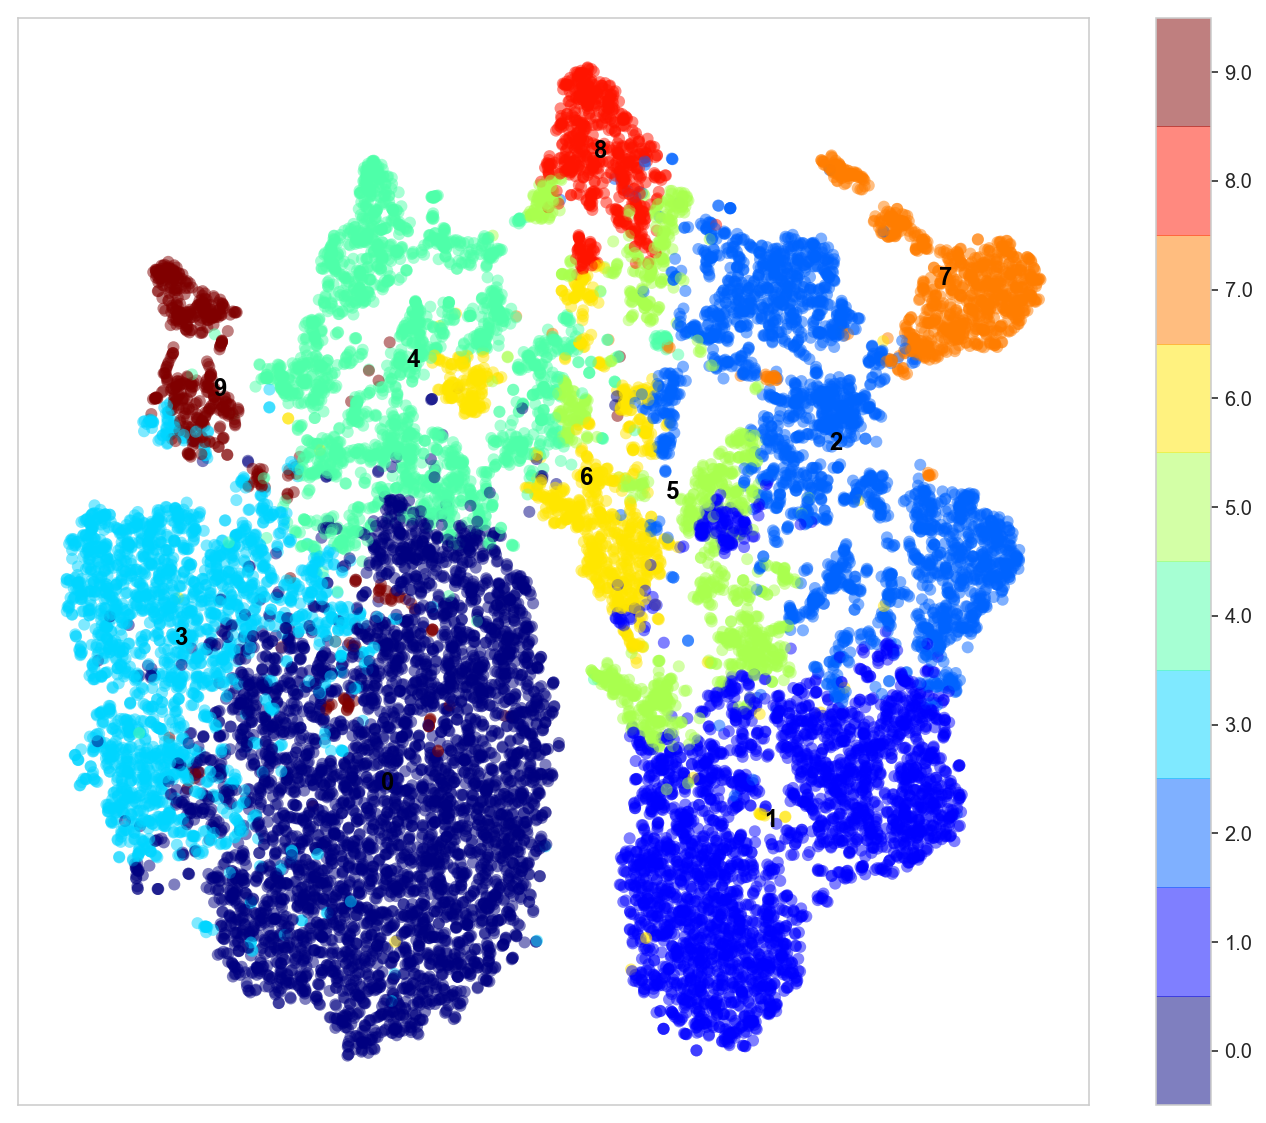

In [33]:
print('tSNE on LSA normalized vs graph clusters')
plot_colored(results_lsa_tsne.values, graph_clusters, 'tsne', n_clusters, show_centers=True)

In [35]:
# print('Our clusters into Cell Ranger ATAC coordinates') 
# mergeddf = pd.merge(pd.DataFrame({'Barcode': results_lsa_tsne.index, 'Cluster': graph_clusters}),
#                     right=tsne10xdf, 
#                     left_on='Barcode', right_on='Barcode')

# print('tSNE on LSA normalized vs Cell Ranger ATAC clusters')
# plot_colored(mergeddf[['TSNE-1', 'TSNE-2']].values, mergeddf['Cluster'], 
#              name='tsne', 
#              n_clusters=len(set(mergeddf['Cluster'])),
#              show_centers=True)

In [36]:
# print('Clusters from Cell Ranger ATAC into our coordinates') 
# mergeddf = pd.merge(pd.DataFrame({'Barcode': results_lsa_tsne.index,
#                                  'tsne1': results_lsa_tsne['tsne1'],
#                                  'tsne2': results_lsa_tsne['tsne2']}),
#                     right=clusters10xdf, 
#                     left_on='Barcode', right_on='Barcode')

# print('tSNE on LSA normalized vs Cell Ranger ATAC clusters')
# plot_colored(mergeddf[['tsne1', 'tsne2']].values, mergeddf['Cluster'], 
#              name='tsne', 
#              n_clusters=len(set(mergeddf['Cluster'])),
#              show_centers=True)

# BigWig RPM normalized profiles

**Pipeline** Split UMI reads by clusters and use RPKM normalization.

<hr>

**Seurat** We created pseudo-bulk ATAC-seq profiles by pooling together cells with for each cell type. Each cell type showed enriched accessibility near canonical marker genes. Chromatin accessibility tracks are normalized to sequencing depth (RPKM normalization) in each pooled group.

**SnapATAC** Next we aggregate cells from the each cluster to create an ensemble track for peak calling and visualization. 

In [59]:
print('Loading full fragments dataframe')
fdf = pd.read_csv(fragments_file, sep='\t', names=['chr', 'start', 'end', 'barcode', 'reads'])

Loading full fragments dataframe


In [60]:
print('Aggregating fragments and clusters')
df_for_bigwigs = pd.merge(left=fdf, right=graph_clusters_df,
                          left_on='barcode', right_on=graph_clusters_df.index)
display(df_for_bigwigs.head()) # already sorted by chromosomes

Aggregating fragments and clusters


chr    start      end             barcode  reads  cluster
0  chr1  3000081  3000285  TGGGTGCTCCTCCTGA-1      1      5.0
1  chr1  3978332  3978494  TGGGTGCTCCTCCTGA-1      3      5.0
2  chr1  4857768  4857846  TGGGTGCTCCTCCTGA-1      5      5.0
3  chr1  7692635  7692751  TGGGTGCTCCTCCTGA-1      1      5.0
4  chr1  9439541  9439724  TGGGTGCTCCTCCTGA-1      1      5.0

## Writing BigWig files

In [61]:
import glob
import pyBigWig

step = 100
bigwigs_path = OUTPUT_DIR + '/bigwig'
! mkdir -p {bigwigs_path}
print('Cleanup bigwigs_path', bigwigs_path)
for f in glob.glob('{}/cluster_*.bw'.format(bigwigs_path)):
    os.remove(f)

    
for cluster in range(n_clusters):
    bw_path = bigwigs_path + '/cluster_{}.bw'.format(cluster)
    print('Processing cluster', cluster, bw_path)
    df_for_bigwigs_cluster = df_for_bigwigs.loc[df_for_bigwigs['cluster'] == cluster]
    chr_lengths = df_for_bigwigs_cluster[['chr', 'end']].groupby('chr').max().reset_index()

    with pyBigWig.open(bw_path, 'w') as bw:
        bw.addHeader(list(zip(chr_lengths['chr'], chr_lengths['end'])))
        for chromosome in tqdm(chr_lengths['chr']):
            df_for_bigwigs_cluster_chr =\
                df_for_bigwigs_cluster.loc[df_for_bigwigs_cluster['chr'] == chromosome].sort_values(['start', 'end'])

            starts = list(df_for_bigwigs_cluster_chr['start'])
            ends = list(df_for_bigwigs_cluster_chr['end'])
            reads = list(df_for_bigwigs_cluster_chr['reads'])
            chr_length = int(chr_lengths.loc[chr_lengths['chr'] == chromosome]['end'])
            values = np.zeros(int(math.floor(chr_length / step)) + 1)

            for i in range(len(df_for_bigwigs_cluster_chr)):
                # Ignore PCR duplicates here!
                # v = reads[i] 
                v = 1.0
                si = int(math.floor(starts[i] / step)) 
                ei = int(math.floor(ends[i] / step)) 
                if ei == si:
                    values[si] += v
                else:
                    values[si] += v / 2 
                    values[ei] += v / 2
            
            non_zero = values > 0
            non_zero_inds = np.flatnonzero(non_zero)
            starts_np = non_zero_inds * step
            ends_np = (non_zero_inds + 1) * step
            values_np = values[non_zero]
            # RPM normalization
            values_np = values_np * (1000000.0 / sum(values_np))
            chroms_np = np.array([chromosome] * sum(non_zero))
            bw.addEntries(chroms_np, starts=starts_np, ends=ends_np, values=values_np)                     

print('Done')

Cleanup bigwigs_path /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig
Processing cluster 0 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_0.bw



Processing cluster 1 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_1.bw



Processing cluster 2 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_2.bw



Processing cluster 3 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_3.bw



Processing cluster 4 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_4.bw



Processing cluster 5 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_5.bw



Processing cluster 6 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_6.bw



Processing cluster 7 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_7.bw



Processing cluster 8 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_8.bw



Processing cluster 9 /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/bigwig/cluster_9.bw



Done


# Closest genes annotation

**Pipeline** Preprocess GENES to TSS and use `bedtools closest -D b` to report distance to TSS, upstream or downstream w.r.t. the gene strand.

<hr>

**Cell Ranger ATAC** We use `bedtools closest -D b` to associate each peak with genes based on closest transcription start sites (packaged within the reference) such that the peak is within 1000 bases upstream or 100 bases downstream of the TSS.

In [40]:
def locations_closest_genes(locations, transcripts_tss):
    print('Annotate list of locations in format "chr:start-end" with closest tss of genes')
    with tempfile.NamedTemporaryFile(delete=False) as f:
        # Save index to restore original order after sorting
        for i, t in enumerate([re.split(':|-', p) for p in locations]):
            f.write('{}\t{}\t{}\t{}\n'.format(*t, i).encode('utf-8'))
        f.close()
        closest_file = f.name + '.closest'
        sorted_file = f.name + '.sorted'
        ! sort -k1,1 -k2,2n {f.name} > {sorted_file}
        ! bedtools closest -a {sorted_file} -b {transcripts_tss} -D b > {closest_file}
        closest_df = pd.read_csv(
            closest_file, sep='\t', 
            names=['chr', 'start', 'end', 'index', 
                   'gene_chr', 'gene_start', 'gene_end', 'gene', 'gene_score', 'gene_strand', 'distance'])
        # Restore original sorting as 
        closest_df.sort_values(by=['index'], inplace=True)
        # Pick only first closest gene in case of several
        closest_df.drop_duplicates(['index'], inplace=True)
        return closest_df[['chr', 'start', 'end', 'gene', 'distance']]


closest_genes = locations_closest_genes(list(normdf.index), transcripts_tss)
# Restore 'peak' to be able to merge on it
closest_genes['peak'] = closest_genes['chr'] +\
                        ':' + closest_genes['start'].astype(str) +\
                        '-' + closest_genes['end'].astype(str)
display(closest_genes.head())

Annotate list of locations in format "chr:start-end" with closest tss of genes


chr      start        end           gene  distance  \
9601  chr10  100148246  100148468        Gm25287      3993   
9603  chr10  100486666  100488009          Tmtc3         0   
9608  chr10  100521925  100521974         Cep290     13200   
9611  chr10  100588658  100589542  4930430F08Rik         0   
9615  chr10  100629796  100630093  1700017N19Rik     20642   

                           peak  
9601  chr10:100148246-100148468  
9603  chr10:100486666-100488009  
9608  chr10:100521925-100521974  
9611  chr10:100588658-100589542  
9615  chr10:100629796-100630093

# Save cluster mean values

In [41]:
# Transpose to (barcodes x peaks) format
t = normdf.T 

# Per cluster mean values for peaks
clusters_means = {str(c): t.loc[clusters == c].mean() for c in range(n_clusters)}
clusters_means_df = pd.DataFrame(clusters_means).reset_index()[[str(c) for c in range(n_clusters)]]
result = pd.concat([closest_genes.reset_index(), clusters_means_df], axis=1).drop(columns=['index'])

print('Saving clusters peaks_means to clusters_peaks_values.tsv')
display(result.head())
result.to_csv(OUTPUT_DIR + '/clusters_peaks_values.tsv', sep='\t', index=False)

Saving clusters peaks_means to clusters_peaks_values.tsv


chr      start        end           gene  distance  \
0  chr10  100148246  100148468        Gm25287      3993   
1  chr10  100486666  100488009          Tmtc3         0   
2  chr10  100521925  100521974         Cep290     13200   
3  chr10  100588658  100589542  4930430F08Rik         0   
4  chr10  100629796  100630093  1700017N19Rik     20642   

                        peak         0         1         2         3  \
0  chr10:100148246-100148468  0.006317  0.000355  0.000304  0.017204   
1  chr10:100486666-100488009  0.035820  0.035570  0.037806  0.038326   
2  chr10:100521925-100521974  0.002900  0.002074  0.000000  0.006530   
3  chr10:100588658-100589542  0.057804  0.066648  0.047958  0.053179   
4  chr10:100629796-100630093  0.004067  0.009323  0.001652  0.010793   

          4         5         6         7         8         9  
0  0.001737  0.000128  0.007897  0.000605  0.000000  0.012109  
1  0.028352  0.029187  0.033563  0.021162  0.038292  0.026821  
2  0.001860  0.000746  0.001202  0.000000  0.000000  0.001353  
3  0.042596  0.036839  0.072438  0.055379  0.047438  0.035187  
4  0.004320  0.002907  0.006770  0.003427  0.000279  0.000448

Hierarchical clustering of clusters mean values


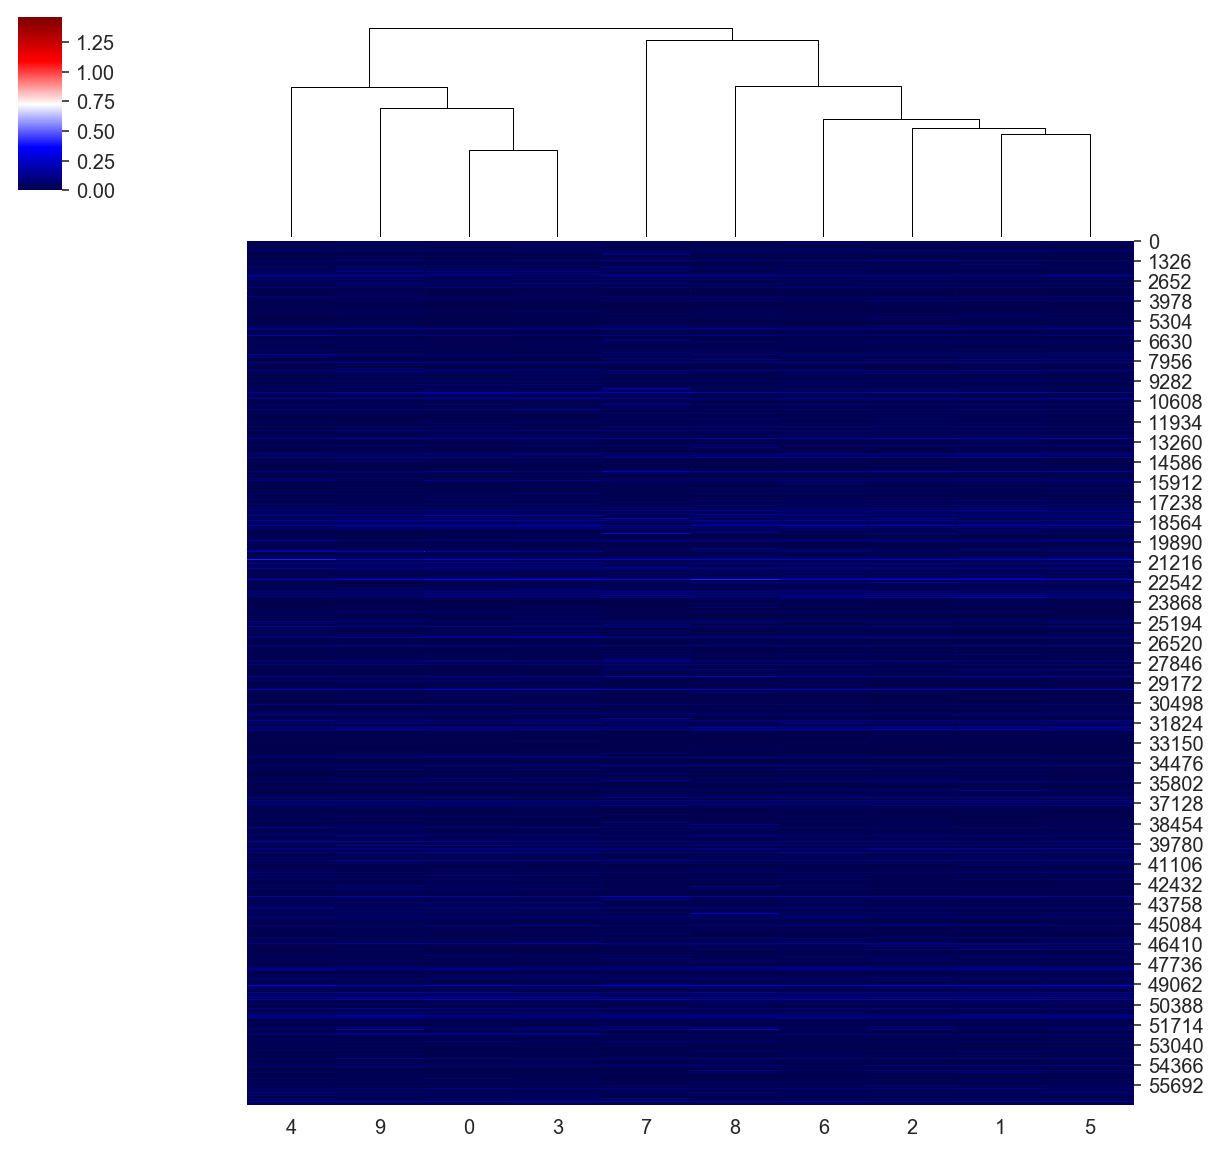

In [42]:
print('Hierarchical clustering of clusters mean values')
sns.clustermap(result[[str(i) for i in range(10)]], col_cluster=True, row_cluster=False, figsize=(10, 10), cmap=plt.cm.seismic)
plt.show()

# Differential peaks (Markers)

**Pipeline**

Reuse Cell Ranger ATAC to get differential markers. 
For each peak we perform test cluster vs others, so that several clusters may yield significant results vs others, we take into account only the cluster with greatest mean value.
Testis is perfromed using Cell Ranger default testing procedure based on Negative Binomial GLM.

In [45]:
# Launch 10x Genomics Cell Ranger DE
from diffexp import *

def run_10x_differential_expression(df, normdf, clusters, fdr=0.05):
    """ Compute differential expression for each cluster vs all other cells
        Args: df          - feature expression data (peak x barcode)
              clusters    - 0-based cluster labels
              fdr         - false discovery rate"""

    peaks = list(df.index)
    n_clusters = len(set(clusters))
    print('Detected clusters', n_clusters)

    print("Computing params...")
    m = df.values
    sseq_params = compute_sseq_params(m)
    
    cluster_markers = []
    for cluster in range(n_clusters):
        in_cluster = clusters == cluster
        group_a = np.flatnonzero(in_cluster)
        group_b = np.flatnonzero(np.logical_not(in_cluster))
        print('Computing DE for cluster {}...'.format(cluster))

        de_result = sseq_differential_expression(m, group_a, group_b, sseq_params)
        de_result['cluster'] = [cluster] * len(de_result)
        de_result['peak'] = peaks
        passed_fdr = de_result['adjusted_p_value'] < fdr
        passed_log2_fc = de_result['log2_fold_change'] > 0
        # Filter out different by statistical tests with log2 fold change > 0
        passed = np.logical_and(passed_fdr, passed_log2_fc)
        print('DE:', sum(passed), 'of', len(de_result), 
              'FDR:', sum(passed_fdr), 'log2fc>0:', sum(passed_log2_fc))

        passed_de = de_result.loc[passed]
        cluster_de_markers = passed_de[
            ['cluster', 'peak', 'norm_mean_a', 'norm_mean_b', 'log2_fold_change', 'p_value', 'adjusted_p_value']
        ].rename(columns={'norm_mean_a': 'x', 'norm_mean_b': 'others', 
                          'log2_fold_change': 'logfc', 'p_value': 'pval', 'adjusted_p_value': 'adjusted_pval'})

        cluster_markers.append(cluster_de_markers)    

    return pd.concat(cluster_markers)

In [46]:
# Combined SSEQ with fold change and max mean filtration
markers10x = run_10x_differential_expression(fulldf, normdf, graph_clusters)
print('Total markers', len(markers10x))
display(markers10x.head())

Detected clusters 10
Computing params...
Computing DE for cluster 0...


Computing 56181 exact tests and 809 asymptotic tests.


DE: 12174 of 56990 FDR: 31928 log2fc>0: 23163
Computing DE for cluster 1...


Computing 56215 exact tests and 775 asymptotic tests.


DE: 14605 of 56990 FDR: 35363 log2fc>0: 23580
Computing DE for cluster 2...


Computing 55959 exact tests and 1031 asymptotic tests.


DE: 13746 of 56990 FDR: 30453 log2fc>0: 25053
Computing DE for cluster 3...


Computing 56988 exact tests and 2 asymptotic tests.


DE: 11002 of 56990 FDR: 22579 log2fc>0: 26573
Computing DE for cluster 4...


Computing 50697 exact tests and 6293 asymptotic tests.


DE: 19881 of 56990 FDR: 40019 log2fc>0: 29526
Computing DE for cluster 5...


Computing 55776 exact tests and 1214 asymptotic tests.


DE: 12744 of 56990 FDR: 26866 log2fc>0: 30293
Computing DE for cluster 6...


Computing 56975 exact tests and 15 asymptotic tests.


DE: 562 of 56990 FDR: 727 log2fc>0: 29958
Computing DE for cluster 7...


Computing 56989 exact tests and 1 asymptotic tests.


DE: 6734 of 56990 FDR: 16601 log2fc>0: 21938
Computing DE for cluster 8...


Computing 56990 exact tests and 0 asymptotic tests.


DE: 6505 of 56990 FDR: 16123 log2fc>0: 22940
Computing DE for cluster 9...


Computing 56988 exact tests and 2 asymptotic tests.


DE: 8869 of 56990 FDR: 19241 log2fc>0: 27427
Total markers 106822


cluster                       peak         x    others     logfc  \
0         0  chr10:100148246-100148468  0.007189  0.002511  1.545269   
5         0  chr10:100654258-100654416  0.005841  0.002657  1.175144   
20        0  chr10:105834673-105835020  0.010335  0.005196  1.014592   
21        0  chr10:105840713-105842042  0.149628  0.125267  0.257927   
29        0  chr10:108150347-108150571  0.007414  0.003328  1.185791   

        pval  adjusted_pval  
0   0.000160       0.000438  
5   0.001419       0.003312  
20  0.001683       0.003870  
21  0.015718       0.029733  
29  0.002224       0.005008

# Markers analysis
* Summary
* Top markers visualization on heatmap / T-SNE

In [47]:
markers = markers10x
t = markers[['cluster']].copy()
t['count'] = 1
display(pd.pivot_table(t, values='count', index=['cluster'], aggfunc=np.sum))

count
cluster       
0        12174
1        14605
2        13746
3        11002
4        19881
5        12744
6          562
7         6734
8         6505
9         8869

# Annotate markers with genes

In [48]:
markers_with_genes = pd.merge(left=markers[['cluster', 'x', 'others', 'logfc', 'pval', 'adjusted_pval', 'peak']],
                         right=closest_genes,
                         left_on='peak',
                         right_on='peak')
# rearrange columns, sort
markers_with_genes = markers_with_genes[['chr', 'start', 'end', 'peak',
                                         'cluster', 'x', 'others', 'logfc', 
                                         'pval', 'adjusted_pval', 'gene', 'distance']].sort_values(
    by=['cluster', 'adjusted_pval'])
display(markers_with_genes.head())

print('Saving all the markers', len(markers_with_genes), 'to markers.tsv')
markers_with_genes.to_csv(OUTPUT_DIR+ '/markers.tsv', sep='\t', index=None)

chr      start        end                       peak  cluster  \
5480   chr12   76552064   76553506    chr12:76552064-76553506        0   
7699   chr13   83571673   83572861    chr13:83571673-83572861        0   
22104   chr3  143674181  143675297   chr3:143674181-143675297        0   
21956   chr3  135191639  135192471   chr3:135191639-135192471        0   
4587   chr12  105596810  105597917  chr12:105596810-105597917        0   

              x    others     logfc          pval  adjusted_pval      gene  \
5480   0.264883  0.070734  1.905216  1.477832e-89   5.614775e-86  AI463170   
7699   0.265107  0.070968  1.901684  2.089950e-89   7.444142e-86     Mef2c   
22104  0.176813  0.039323  2.169266  6.348786e-86   1.809087e-82   Gm24728   
21956  0.204672  0.051029  2.004394  6.028259e-85   1.431460e-81   Gm43033   
4587   0.168950  0.041687  2.019534  1.285712e-76   1.704017e-73    Bdkrb1   

       distance  
5480      -4122  
7699          0  
22104         0  
21956    -16516  
4587      -5168

Saving all the markers 106822 to markers.tsv


# Analyzing top markers

In [49]:
def get_top_markers(df, n_clusters=n_clusters, top=100):
    top_markers = pd.concat([
        df.loc[df['cluster'] == c].sort_values(by=['adjusted_pval']).head(top) 
                    for c in range(0, n_clusters)])
    top_markers['peak'] = top_markers['chr'] +\
                          ':' + top_markers['start'].astype(str) + '-'\
                          + top_markers['end'].astype(str)
    return top_markers


top_markers = get_top_markers(markers_with_genes, top=50)
display(get_top_markers(markers_with_genes, top=1))

chr      start        end                       peak  cluster  \
5480    chr12   76552064   76553506    chr12:76552064-76553506        0   
63951    chr6   28350911   28351660     chr6:28350911-28351660        1   
77298    chr1   54660455   54661226     chr1:54660455-54661226        2   
1249    chr10   60413625   60414227    chr10:60413625-60414227        3   
30971    chr7   44531068   44535216     chr7:44531068-44535216        4   
37481   chr11  108919974  108923032  chr11:108919974-108923032        5   
67288    chr7   99086643   99087689     chr7:99086643-99087689        6   
102947  chr10   61261057   61261858    chr10:61261057-61261858        7   
105141   chr2  159134037  159134575   chr2:159134037-159134575        8   
106248  chr19    6322043    6322561      chr19:6322043-6322561        9   

               x    others     logfc           pval  adjusted_pval      gene  \
5480    0.264883  0.070734  1.905216   1.477832e-89   5.614775e-86  AI463170   
63951   0.122152  0.014796  3.044851  4.012424e-152  1.143340e-147    Gm5303   
77298   0.171905  0.015462  3.473338  1.367560e-223  7.793726e-219   Ankrd44   
1249    0.108088  0.015439  2.812563   1.794531e-45   1.022703e-40     Cdh23   
30971   0.224610  0.074436  1.593139  2.251629e-100   2.138673e-97     Pold1   
37481   0.150738  0.057549  1.389999   5.044530e-49   5.749755e-46     Axin2   
67288   0.134322  0.071423  0.915139   2.114734e-10   1.205187e-05   Gm33882   
102947  0.266904  0.004093  6.020747  3.408889e-185  1.942726e-180  Adamts14   
105141  0.156892  0.003334  5.551390  2.289300e-150  1.304672e-145   Gm25090   
106248  0.112806  0.000993  6.798009  5.318563e-159  3.031049e-154  Cdc42bpg   

        distance  
5480       -4122  
63951      11505  
77298      -2769  
1249       -7173  
30971          0  
37481          0  
67288      -2543  
102947     11384  
105141     -4786  
106248       236

Computing Z scores for mean values in cluster for markers
Clustermap of Z scores


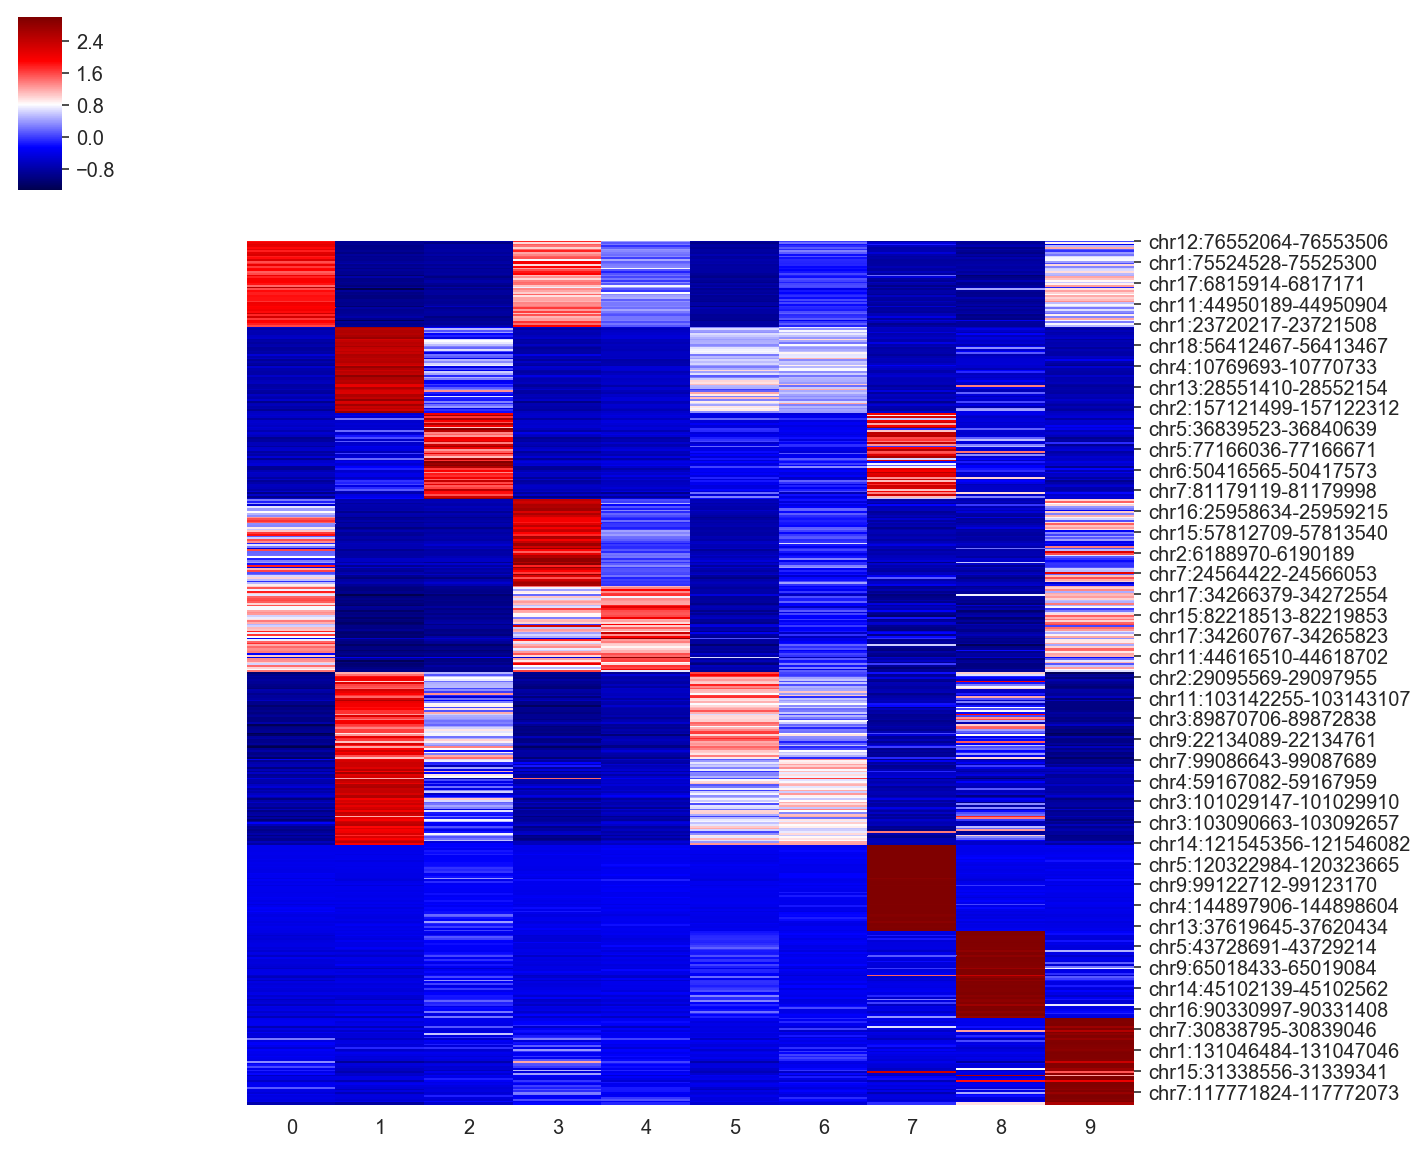

In [50]:
print('Computing Z scores for mean values in cluster for markers')
t = normdf.T # Transpose to (barcodes x peaks) format
t = t[list(top_markers['peak'])] # top markers only

t = pd.concat([pd.DataFrame(t.loc[clusters == cluster].mean()).T for cluster in range(n_clusters)])
t.index = range(n_clusters)

# Transform to Z-score
for c in t.columns:
    t[c] = zscore(t[c])

print('Clustermap of Z scores')
sns.clustermap(t.T, col_cluster=False, row_cluster=False, figsize=(10, 10), cmap=plt.cm.seismic)
plt.show()

t-SNE based Z-SCORE visualizations for markers, mean z-score for each cell is given


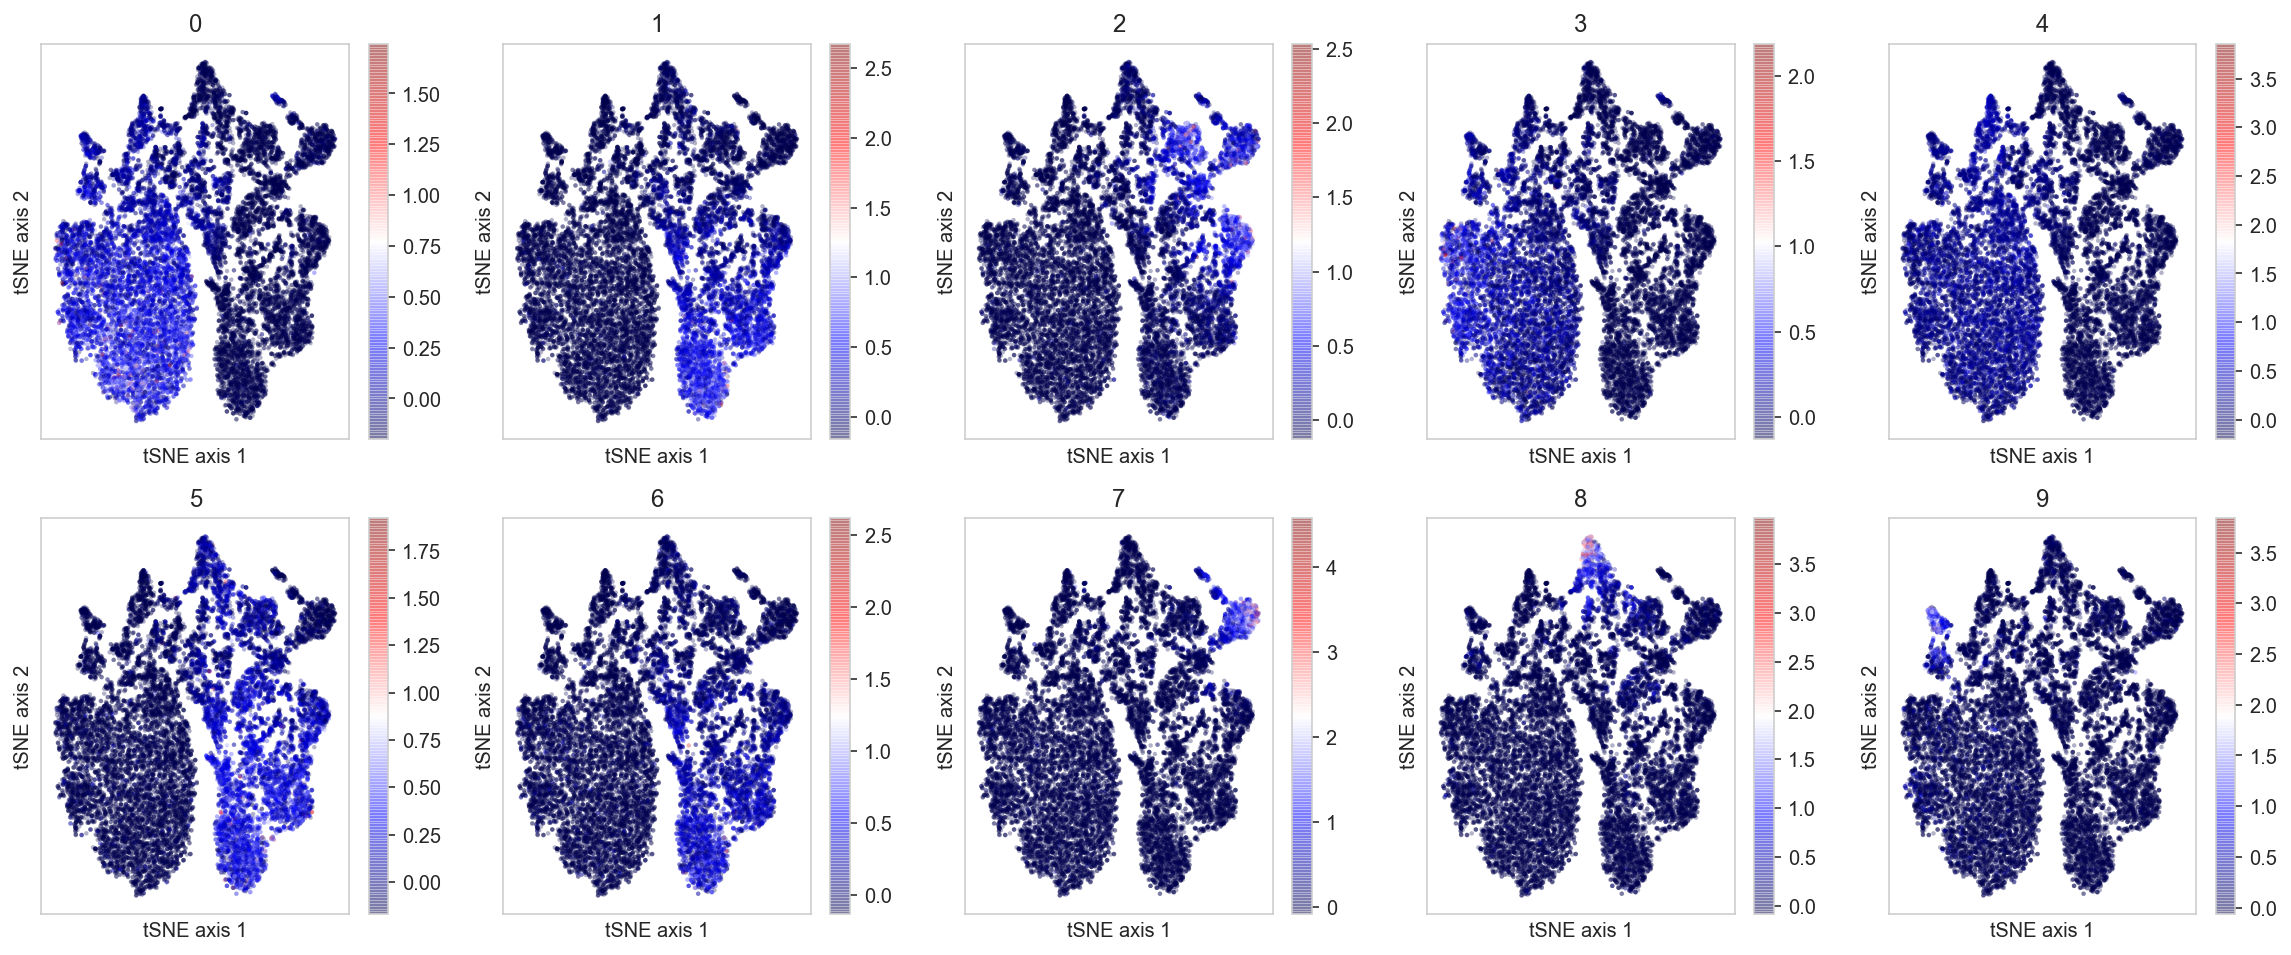

In [51]:
print('t-SNE based Z-SCORE visualizations for markers, mean z-score for each cell is given')
nrows = max([c for c in range(1, math.ceil(math.sqrt(n_clusters))) if n_clusters % c == 0])
ncols = int(n_clusters / nrows)

t = normdf

plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
for cluster in tqdm(range(n_clusters)):
    # Table (marker for cluster x cells)
    markers_df = t.loc[top_markers.loc[top_markers['cluster'] == cluster]['peak']].T.copy()

    # Z scale for each marker peak across all cells
    for c in markers_df.columns:
        markers_df[c] = zscore(markers_df[c])
    
    # Average Z score for each cell
    zscores = markers_df.T.mean()
    t1 = results_lsa_tsne['tsne1']
    t2 = results_lsa_tsne['tsne2']
    ax = plt.subplot(nrows, ncols, cluster + 1)
    plt.setp(ax, xticks=[], yticks=[])
    sc = ax.scatter(t1, t2, s=5, c=zscores, cmap=plt.cm.seismic, edgecolor='none', alpha=0.3)
    plt.colorbar(sc)
    plt.title(str(cluster))
    plt.xlabel('tSNE axis 1')
    plt.ylabel('tSNE axis 2')
plt.show()

# Differential markers to BED


In [86]:
cluster_peaks_path = os.path.join(OUTPUT_DIR, 'markers')
! mkdir -p {cluster_peaks_path}
print('Cleanup peaks_clusters', cluster_peaks_path)
for f in glob.glob('{}/markers_*.bed'.format(cluster_peaks_path)):
    os.remove(f)

mlap_max = (-np.log10(markers.loc[markers['adjusted_pval'] != 0]['adjusted_pval'])).max()
print('BED scoring as -log10 adjusted pval')
print('Max of -log10 adjusted pval', mlap_max)

for c in range(n_clusters):
    bed_file = '{}/markers_{}.bed'.format(cluster_peaks_path, c)
    markers_cluster = markers.loc[markers['cluster'] == c].sort_values(['logfc'], ascending=False).iloc[::-1]
    markers_cluster.index = range(len(markers_cluster))
    print('Writing cluster', c, 'differential peaks to', bed_file)
    with open(bed_file, 'w') as bed:
        for i in range(len(markers_cluster)):
            peak = markers_cluster['peak'][i]
            ap = markers_cluster['adjusted_pval'][i]
            mlap = -np.log10(ap) if ap != 0.0 else mlap_max
            line = '{}\t{}\t{}\t.\n'.format(
                re.sub(':|-', '\t', peak), 
                c,
                mlap)
            bed.write(line)
print('Done')                

Cleanup peaks_clusters /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers
BED scoring as -log10 adjusted pval
Max of -log10 adjusted pval 218.1082548430905
Writing cluster 0 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_0.bed
Writing cluster 1 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_1.bed
Writing cluster 2 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_2.bed
Writing cluster 3 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_3.bed
Writing cluster 4 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_4.bed
Writing cluster 5 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_5.bed
Writing cluster 6 differential peaks to /Users/oleg/Desktop/2019_gxfer1_DT1634_Denis/pipeline/markers/markers_6.bed
Writing cluster 7 dif

# TOP markers and associated genes
You can copy and paste any of these lists directly to JBR Genome Browser.

In [55]:
print('Top markers genes with biggest log fold change')
top_markers = get_top_markers(markers_with_genes, top=10)

for cluster in range(n_clusters):
    print('Cluster', cluster)
    cluster_top = top_markers.loc[top_markers['cluster'] == cluster]
    print(', '.join(set(cluster_top['gene'])))
    print('---')
    print(', '.join(cluster_top['peak']))
    print('\n')

Top markers genes with biggest log fold change
Cluster 0
Gm44714, AI463170, Usp45, Bdkrb1, Gm43033, Mef2c, Gm49134, Gm20753, Gm24728, Noa1
---
chr12:76552064-76553506, chr13:83571673-83572861, chr3:143674181-143675297, chr3:135191639-135192471, chr12:105596810-105597917, chr14:47164953-47166347, chr8:11097872-11099129, chr4:21754907-21755954, chr1:106162326-106163255, chr5:77289271-77290362


Cluster 1
Ccdc33, Ifngas1, Gm2862, Bambi-ps1, Gm49475, Kif1b, Gm25574, Adamts14, Ect2l, Gm5303
---
chr6:28350911-28351660, chr15:100181346-100183371, chr4:149282122-149283113, chr10:61232811-61233713, chr2:122468944-122469843, chr9:58112153-58112885, chr15:25695641-25696425, chr3:38279960-38280896, chr10:18192991-18193875, chr10:118633269-118634107


Cluster 2
Gm4266, Gnptab, Ankrd44, Rdx, Slc35f3, AC165408.2, Ascc1, Vrk1, Man2b2, Lrrc8d
---
chr1:54660455-54661226, chr9:52069930-52070532, chr10:88427769-88428533, chr18:82244411-82245483, chr8:126199957-126200686, chr12:106008430-106009187, chr10:6

# Reference markers analysis

Take into account only close to TSS markers


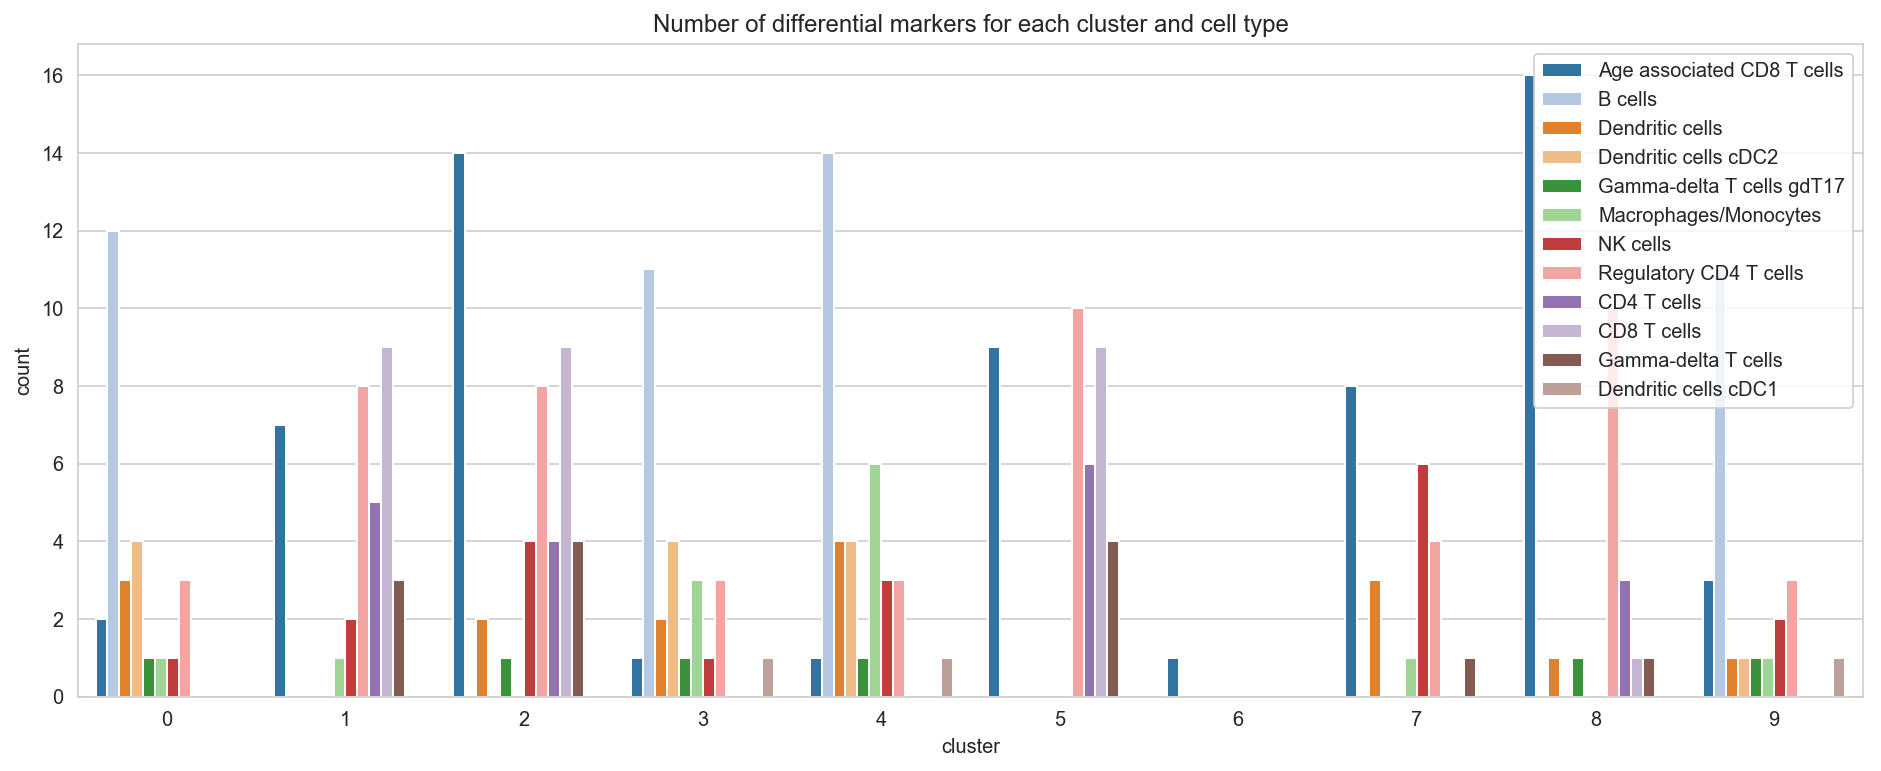

In [84]:
from collections import Counter

print('Take into account only close to TSS markers')
t1 = markers_with_genes.copy()
t1 = t1.loc[np.logical_and(t1['distance'] > -10000, t1['distance'] < 10000)]
t1['gene_lower'] = [g.lower() for g in t1['gene']]
t2 = pd.DataFrame(columns=['cell', 'gene', 'gene_lower'])
for k,v in MARKER_GENES_TABLE.items():
    for gene in v:
        t2.loc[len(t2)] = (k, gene, gene.lower())
t = pd.merge(left=t1, right=t2, left_on='gene_lower', right_on='gene_lower')[['cluster', 'cell']]
t['count'] = [1] * len(t)
t = pd.pivot_table(t, values='count', index=['cluster', 'cell'], aggfunc='count').reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(data=t, x="cluster", y="count", hue="cell", palette='tab20')
plt.legend(loc='upper right')
plt.title('Number of differential markers for each cluster and cell type')
plt.show()

# Preparation data for single cell explorer
Preprocess data for single cell explorer http://artyomovlab.wustl.edu/shiny/single_cell_explorer

Upload `data_for_plot.tsv`, `expData.Rda` and `markers.tsv` to corresponding single cell explorer folder and voila!

In [57]:
from scipy import io, sparse
sce_path = os.path.join(OUTPUT_DIR, 'sce')
! mkdir -p {sce_path}

print('Save data_for_plot.tsv')
barcodes = normdf.transpose().index.values
data_for_plot = pd.DataFrame(
    {'tSNE_1': results_lsa_tsne['tsne1'], 
     'tSNE_2': results_lsa_tsne['tsne2'], 
     'Cluster': graph_clusters,
     'nCounts': fulldf.sum()})
data_for_plot.index = barcodes
data_for_plot.to_csv(os.path.join(sce_path, 'data_for_plot.tsv'), sep='\t')

print('Save RPM expData.Rda.mtx')
csc = sparse.csc_matrix(normdf.values)
io.mmwrite(os.path.join(sce_path, 'expData.Rda.mtx'), csc)

print('Save barcodes.txt')
with open(os.path.join(sce_path, 'barcodes.txt'), 'w') as f:
    for b in normdf.columns.values:
        f.write(b + '\n')

print('Save peaks.txt')
with open(os.path.join(sce_path, 'peaks.txt'), 'w') as f:
    for p in normdf.index.values:
        f.write(p + '\n')

print('Save markers.tsv')
top_markers.to_csv(os.path.join(sce_path, 'markers.tsv'), index=None, sep='\t')
        
print('Done')

Save data_for_plot.tsv
Save RPM expData.Rda.mtx
Save barcodes.txt
Save peaks.txt
Save markers.tsv
Done


In [58]:
print('Converting to Rda format in R')

R_CODE = """
require(readr)
require(Matrix)
library(magrittr)

barcodes <- readr::read_tsv('{0}/barcodes.txt', col_names = F)
peaks <- readr::read_tsv('{0}/peaks.txt', col_names = F)
expData <- Matrix::readMM('{0}/expData.Rda.mtx') %>%
    magrittr::set_rownames(peaks$X1) %>%
    magrittr::set_colnames(barcodes$X1)
save(expData, file = "{0}/expData.Rda")
""".format(sce_path)

with tempfile.NamedTemporaryFile(prefix='prepare', suffix='.R', delete=False) as f:
    f.write(R_CODE.encode('utf-8'))
    f.close()
    ! Rscript {f.name}

print('Done')


Converting to Rda format in R
Loading required package: readr
Loading required package: Matrix
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Done
